## Functions for adding trigger i.e poison

In [57]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import random
import seaborn as sns
from collections import Counter

from PIL import Image
from skimage import io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim

import torchvision.datasets
import torchvision.transforms as T 
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader
from matplotlib.ticker import MaxNLocator
from torchvision.models import resnet50,resnet152

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import cv2
import random
import math
from tqdm import tqdm
from sklearn.metrics import silhouette_score
import torch, torchvision
import shutil
import re


def overlay_image_alpha(img, img_overlay, x, y, alpha_mask):
    """
    Overlay `img_overlay` onto `img` at (x, y) position and blend using `alpha_mask`.

    Parameters:
    - img: The main image
    - img_overlay: The image we want to overlay on the main image
    - x, y: The top-left position where we want to place `img_overlay` on `img`
    - alpha_mask: A mask to use for blending (must have values in the range [0, 1])
    """
    # Define the region of interest in the main image where the overlay will be placed
    y1, y2 = max(0, y), min(img.shape[0], y + img_overlay.shape[0])
    x1, x2 = max(0, x), min(img.shape[1], x + img_overlay.shape[1])

    # Define the region of interest in the overlay image
    y1o, y2o = max(0, -y), min(img_overlay.shape[0], img.shape[0] - y)
    x1o, x2o = max(0, -x), min(img_overlay.shape[1], img.shape[1] - x)

    # Check if overlay and main image intersect, if not, return
    if y1 >= y2 or x1 >= x2 or y1o >= y2o or x1o >= x2o:
        return

    # Blend overlay within the determined regions
    img_crop = img[y1:y2, x1:x2]
    img_overlay_crop = img_overlay[y1o:y2o, x1o:x2o]
    alpha = alpha_mask[y1o:y2o, x1o:x2o, np.newaxis]  # Add an extra dimension for broadcasting
    alpha_inv = 1.0 - alpha

    img_crop[:] = alpha * img_overlay_crop + alpha_inv * img_crop



def add_patch_to_image(img, patch_path, position_state, patch_coverage_percentage):
    # Load the main image using OpenCV
    height, width = img.shape[:2]
    original_img_size=(height, width )
    img = cv2.resize(img, (224, 224))

    # Load the patch using OpenCV
    original_patch = cv2.imread(patch_path, cv2.IMREAD_UNCHANGED)
    

    # Calculate the desired patch area based on the coverage percentage
    desired_patch_area = patch_coverage_percentage * (224 * 224)
    patch_dimension = int(np.sqrt(desired_patch_area))
    # Resize the patch
    resized_patch = cv2.resize(original_patch, (patch_dimension, patch_dimension))

    height, width = img.shape[:2]
    center_x, center_y = width // 2, height // 2
    radius=80
    # Adjust radius to ensure the entire patch stays within image boundaries
    adjusted_radius = max(0, radius - patch_dimension)
    #         img_visualization=img
    #         cv2.circle(img_visualization, (center_x, center_y), radius, (255, 255, 0), 2)
    #         img_rgb = cv2.cvtColor(visualization_img, cv2.COLOR_BGR2RGB)
    #         plt.imshow(img_rgb)
    #         plt.show()

    # Random angle and distance within the adjusted radius
    angle = random.uniform(0, 2 * math.pi)
    dist = random.uniform(0, adjusted_radius)

    # Choose a random or fixed position within the bounding box for the patch
    if position_state == "Random":

        # Calculate top-left corner of the patch
        x_position = int(center_x + dist * math.cos(angle) - patch_dimension / 2)
        y_position = int(center_y + dist * math.sin(angle) - patch_dimension / 2)

        # Ensure the patch is within image boundaries
        x_position = max(0, min(x_position, width - patch_dimension))
        y_position = max(0, min(y_position, height - patch_dimension))

    else:
        # Calculate the center position for the patch
        x_position = (width - patch_dimension) // 2
        y_position = (height - patch_dimension) // 2


    # Overlay the patch onto the main image
    patch_rgb = resized_patch[:, :, :3]
    patch_alpha = resized_patch[:, :, 3] / 255.0 if resized_patch.shape[2] == 4 else np.ones((patch_rgb.shape[0], patch_rgb.shape[1]))
    #     img=overlay_image_weighted_blend(img, patch_rgb, x_position, y_position,1 )
    overlay_image_alpha(img, patch_rgb, x_position, y_position, patch_alpha)
    return img 


In [58]:
# In[3]:
class CIFAR10_Test_Backoored(Dataset):
    def __init__(self, datasets,transform, patch_path, patch_coverage_percentage, position_state, patched_indices, target_label):
        original_dataset = datasets
        
        # Filter dataset to include only patched images
        self.images_labels = [(original_dataset[i][0], target_label) for i in patched_indices]
        self.transform = transform
        self.patch_path = patch_path
        self.patch_coverage_percentage = patch_coverage_percentage
        self.position_state = position_state
        self.target_label=target_label

    def __len__(self):
        return len(self.images_labels)

    def __getitem__(self, index):
        img, label = self.images_labels[index]
        # Convert PIL image to numpy array for patching
        img = np.array(img)
        # Apply the patch
        img = add_patch_to_image(img, self.patch_path, self.position_state, self.patch_coverage_percentage)
        # Change the label to the target label for patched images
        label = self.target_label
        
        # Convert numpy array back to PIL Image
        img = transforms.ToPILImage()(img)

        # Apply any final transformations
        if self.transform:
            img = self.transform(img)

        return img, label
    
class CIFAR10_Test_Clean(Dataset):
    def __init__(self, datasets,transform, exclude_indices):
        self.original_dataset = datasets
        
#         # Filter dataset to exclude the images at exclude_indices
#         self.images_labels = [(img, lbl) for idx, (img, lbl) in enumerate(original_dataset) if idx not in exclude_indices]
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, index):
        img, label = self.original_dataset[index]
        
        # Convert PIL image to numpy array if any operation needed before transform
        img = np.array(img)

        # Convert numpy array back to PIL Image for consistency
        img = transforms.ToPILImage()(img)

        # Apply any final transformations
        if self.transform:
            img = self.transform(img)

        return img, label
    

class CIFAR10BackdooredTraining(Dataset):
    def __init__(self, datasets, train, download, transform, patch_path, patch_coverage_percentage, position_state, patched_indices, target_label):
        self.dataset = datasets
        self.transform = transform
        self.patch_path = patch_path
        self.patch_coverage_percentage = patch_coverage_percentage
        self.position_state = position_state
        # Store patched_indices as is, assuming it's a list of indices to patch
        self.patched_indices = patched_indices  
        self.target_label = target_label
        # Adjust the length to account for both original and patched images for selected indices
        self.adjusted_length = len(self.dataset) + len(self.patched_indices)

    def __len__(self):
        return self.adjusted_length

    def __getitem__(self, index):
        # Determine if index is beyond the original dataset range
        actual_index=None
        if index >= len(self.dataset):
            # Adjust index to get the corresponding patched index
            patch_index = index - len(self.dataset)
            # Get the actual dataset index for the patched image
            actual_index = self.patched_indices[patch_index]
            img, label = self.dataset[actual_index]
        else:
            # Index within the original range, fetch normally
            img, label = self.dataset[index]
            actual_index = index

        # Convert PIL image to numpy array for potential patching
        img = np.array(img)
        
        # Apply patch if we're dealing with a patched index
        if actual_index in self.patched_indices:
            img = add_patch_to_image(img, self.patch_path, self.position_state, self.patch_coverage_percentage)
            label = self.target_label
        
        # Convert numpy array back to PIL Image for both original and patched
        img = Image.fromarray(img)

        # Apply any final transformations
        if self.transform:
            img = self.transform(img)

        return img, label,index
    
    def get_class_label_by_index(self, index):
        if index >= len(self.dataset):
            # Adjust index to get the corresponding patched index
            patch_index = index - len(self.dataset)
            # Get the actual dataset index for the patched image
            actual_index = self.patched_indices[patch_index]
            img, label = self.dataset[actual_index]
            return label
        else:
            # Index within the original range, fetch normally
            img, label = self.dataset[index]
            return label

## Function to get features/Activation values of the model 

In [59]:
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#function to obtain activation values  
def get_pre_fc_layer_activations(model, input_tensor,device):
    model.eval()
    input_tensor=normalize(input_tensor)
    with torch.no_grad():
        x = input_tensor.to(device)
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        gap = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))
        # Flatten the output for further processing, resulting in shape [N, C]
        activations = torch.flatten(gap, start_dim=1)
        # activations = torch.flatten(x, 1)
        return activations



In [60]:
import torchvision.transforms.functional as TF
def collect_images_by_class(data_loader, class_id, max_images=10):
    collected_images = []
    for images, labels in data_loader:
        for image, label in zip(images, labels):
            if label.item() == class_id and len(collected_images) < max_images:
                collected_images.append(image)
    return collected_images

def count_images_of_specific_class(dataloader, class_id):
    total_images = 0
    for _, labels,_ in dataloader:
        # Count how many times class_id appears in labels
        total_images += torch.sum(labels == class_id).item()
    return total_images

def visualize_image(dataset, index):
    img, label, _ = dataset[index]
    
    # If the transform to tensor is applied in the dataset, convert back to PIL image for visualization
    if not isinstance(img, Image.Image):
        img = TF.to_pil_image(img)
    
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.show()

def copy_suspicious_images(dataset, suspicious_indices, new_root_dir):
    if not os.path.exists(new_root_dir):
        os.makedirs(new_root_dir)
    
    for index in suspicious_indices:
        image_path = dataset.get_image_path_by_index(index)
        # Construct the new path under new_root_dir maintaining the original structure
        new_path = image_path.replace(dataset.root_dir, new_root_dir)
        # Create directories if they do not exist
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        # Copy the file
        shutil.copy2(image_path, new_path)
#         print(f"Copied {image_path} to {new_path}")

def verify_suspicious_indices(dataset, suspicious_indices, expected_class):
    verified_indices = []
    print("starting verification process")
#     patched_indices_set=set(trainloder.dataset.patched_indices)
    for idx in suspicious_indices:
        _, label, _ = dataset[idx]
#         print(f"image id:{idx}")
        if label == expected_class:
            verified_indices.append(idx)
        else:
            visualize_image(dataset,idx)
            print(f"Index {idx} does not belong to expected class {expected_class}, found in class {actual_class}.")
    print("done with verification process")
    return verified_indices


def calculate_fp_fn_cifar(trainloder, suspicious_indices, target_label):
    false_positives = 0
    false_negatives = 0

    # Assuming dataset is an instance of CIFAR10BackdooredTraining
    patched_indices_set = set(trainloder.dataset.patched_indices)
    print("Length of patched indices: ",len(patched_indices_set))
    # False Positives: Count non-backdoored images incorrectly flagged as suspicious
    for idx in suspicious_indices:
        if idx not in patched_indices_set:
            false_positives += 1

    # False Negatives: Count backdoored images not flagged as suspicious
    for idx in patched_indices_set:
        if idx not in suspicious_indices:
            false_negatives += 1

    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")

    # Optionally, calculate rates
    total_suspicious = len(suspicious_indices)
    total_patched = len(patched_indices_set)
    fpr = false_positives / total_suspicious if total_suspicious > 0 else 0
    fnr = false_negatives / total_patched if total_patched > 0 else 0
    print(f"False Positive Rate: {fpr*100:.2f}%")
    print(f"False Negative Rate: {fnr*100:.2f}%")

    return false_positives, false_negatives, fpr, fnr



def visualize_clusters(projected_feats, labels, largest_cluster_center, title='KMeans Clustering'):
    # Assuming projected_feats is 2D or has been reduced to 2 principal components
    plt.figure(figsize=(8, 6))

    clean_label=0
    if labels.sum() >= len(labels) / 2.:
        clean_label = 1
    else:
        clean_label = 0

    poisonous_label = 1 - clean_label  # The other label is considered 'poisonous'
    
    # Plot each cluster using different colors and labels
    plt.scatter(projected_feats[labels == clean_label, 0], projected_feats[labels == clean_label, 1], 
                c='blue', label='Clean', marker='o')
    plt.scatter(projected_feats[labels == poisonous_label, 0], projected_feats[labels == poisonous_label, 1], 
                c='red', label='Poisonous', marker='x')
    
    # Plot the center of the largest cluster
    plt.scatter(largest_cluster_center[0], largest_cluster_center[1], 
                c='gold', label='Largest Cluster Center', marker='*', s=200)  # s is the size of the marker
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()  # Display the legend to differentiate clean, poisonous, and the center
    plt.show()


## Activation Clustering Cleansing

In [68]:
#from sklearn.decomposition import PCA
#from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

def get_features_training(data_loader, model, num_classes, device):
    model.eval()  # Set the model to evaluation mode
    class_indices = [[] for _ in range(num_classes)]  # Initialize class indices
    feats = []  # Initialize the list for storing features
    local_to_global_index_map = {} 

    with torch.no_grad():  # Disable gradient computation
        sid = 0
        for i, (data, target,indices) in enumerate(tqdm(data_loader)):
            data, target = data.to(device), target.to(device)  # Move data to the specified device
            
            extracted_feats = get_pre_fc_layer_activations(model, data, device)  # Extract features
            this_batch_size = len(target)
            # print("batch: ",this_batch_size)
            for bid in range(this_batch_size):
                feats.append(extracted_feats[bid])  # Append extracted features
                b_target = target[bid].item()  # Get the class/target of the sample

                # Append the global dataset index of the sample
                global_index = indices[bid].item()
                local_to_global_index_map[sid+bid] = global_index 

            
                class_indices[b_target].append(sid + bid)  # Append the index of the sample
                # if b_target==14:
                #     print(f"Class: {b_target} || Map Index {sid + bid} ||Dataset Index: {indices[bid].item()} ||path: {data_loader.dataset.get_image_path_by_index(indices[bid].item())}")
            sid += this_batch_size  # Update the sample ID offset

    return feats, class_indices,local_to_global_index_map



# def cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2,num_axes=10):
#     """
#         adapted from : https://github.com/hsouri/Sleeper-Agent/blob/master/forest/filtering_defenses.py
#     """
#     suspicious_indices = []
#     print(f"Num of crusters: {clusters} || number of axes: {num_axes}")
#     feats, class_indices,local_to_global_index_map = get_features_training(inspection_split_loader, model, num_classes,device)

#     myscore=[]
#     max_score=0
#     for target_class in range(num_classes):

#         # print('class - %d' % target_class)

#         if len(class_indices[target_class]) <= 1: continue # no need to perform clustering...

#         temp_feats = [feats[temp_idx].unsqueeze(dim=0) for temp_idx in class_indices[target_class]]
#         temp_feats = torch.cat( temp_feats , dim=0)
#         temp_feats = temp_feats - temp_feats.mean(dim=0)

#         _, _, V = torch.svd(temp_feats, compute_uv=True, some=False)

#         axes = V[:, :num_axes]
#         projected_feats = torch.matmul(temp_feats, axes)
#         projected_feats = projected_feats.cpu().numpy()

#         # print("Shape of projected features: ",projected_feats.shape)

#         # print('start k-means')
#         kmeans = KMeans(n_clusters=clusters,n_init=10).fit(projected_feats)
#         # print('end k-means')

# #         # by default, take the large cluster as the clean cluster (since all inference-time backdoor inputs are in the target class)
# #         if kmeans.labels_.sum() >= len(kmeans.labels_) / 2.:
# #             clean_label = 1
# #         else:
# #             clean_label = 0
#         # Identify the largest cluster
#         cluster_sizes = np.bincount(kmeans.labels_)
#         clean_label = np.argmin(cluster_sizes)
#         print("clean label is: ",clean_label)

#         outliers_local_indices = []
#         for (bool, idx) in zip((kmeans.labels_ == clean_label).tolist(), list(range(len(kmeans.labels_)))):
#             if bool:
#                 outliers_local_indices.append(class_indices[target_class][idx])
        
#           # Map local class-specific indices to global indices
#         outliers_global_indices = [local_to_global_index_map[local_idx] for local_idx in outliers_local_indices]

# #         verify_suspicious_indices(inspection_split_loader.dataset, outliers_global_indices, target_class)

#         score = silhouette_score(projected_feats, kmeans.labels_)
#         print('[class-%d] silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
#         # if score > threshold:# and len(outliers) < len(kmeans.labels_) * 0.35:
#         myscore.append(score)

        
#         if len(outliers_global_indices) < len(kmeans.labels_) * 0.40: # if one of the two clusters is abnormally large
#             # print(f"Outlier Num in Class {target_class}:", len(outliers_global_indices))
#             if max_score<score: 
#                 # verify_suspicious_indices(inspection_split_loader.dataset, outliers_global_indices, target_class)
# #                 visualize_clusters(projected_feats, kmeans.labels_, title=f'Class {target_class} Clustering')
# #                 visualize_clusters(projected_feats, kmeans.labels_, n_clusters=clusters)
#                 suspicious_indices = outliers_global_indices.copy()
#                 max_score=score  
#     most_suspicious_class=np.array(myscore).argmax()
#     print("The poisoned class is: ",most_suspicious_class)
#     return most_suspicious_class,suspicious_indices

def cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2):
    """
        adapted from : https://github.com/hsouri/Sleeper-Agent/blob/master/forest/filtering_defenses.py
    """


    suspicious_indices = []

    feats, class_indices,local_to_global_index_map = get_features_training(inspection_split_loader, model, num_classes,device)

    myscore=[]
    max_score=0
    for target_class in range(num_classes):

        # print('class - %d' % target_class)

        if len(class_indices[target_class]) <= 1: continue # no need to perform clustering...

        temp_feats = [feats[temp_idx].unsqueeze(dim=0) for temp_idx in class_indices[target_class]]
        temp_feats = torch.cat( temp_feats , dim=0)
        temp_feats = temp_feats - temp_feats.mean(dim=0)

        _, _, V = torch.svd(temp_feats, compute_uv=True, some=False)

        axes = V[:, :10]
        projected_feats = torch.matmul(temp_feats, axes)
        projected_feats = projected_feats.cpu().numpy()

        # print("Shape of projected features: ",projected_feats.shape)

        # print('start k-means')
        kmeans = KMeans(n_clusters=clusters,n_init=10).fit(projected_feats)
        # print('end k-means')
        
        # by default, take the large cluster as the clean cluster (since all inference-time backdoor inputs are in the target class)
        if kmeans.labels_.sum() >= len(kmeans.labels_) / 2.:
            clean_label = 1
        else:
            clean_label = 0
#         Identify the largest cluster
        outliers_local_indices = []
        for (bool, idx) in zip((kmeans.labels_ != clean_label).tolist(), list(range(len(kmeans.labels_)))):
            if bool:
                outliers_local_indices.append(class_indices[target_class][idx])
                
        largest_cluster_center = kmeans.cluster_centers_[clean_label]
        
          # Map local class-specific indices to global indices
        outliers_global_indices = [local_to_global_index_map[local_idx] for local_idx in outliers_local_indices]

#         verify_suspicious_indices(inspection_split_loader.dataset, outliers_global_indices, target_class)

        score = silhouette_score(projected_feats, kmeans.labels_)
        print('[class-%d] silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
        # if score > threshold:# and len(outliers) < len(kmeans.labels_) * 0.35:
        myscore.append(score)

        
        if len(outliers_global_indices) < len(kmeans.labels_) * 0.40: # if one of the two clusters is abnormally large
            # print(f"Outlier Num in Class {target_class}:", len(outliers_global_indices))
            if max_score<score: 
                # verify_suspicious_indices(inspection_split_loader.dataset, outliers_global_indices, target_class)
#                 visualize_clusters(projected_feats, kmeans.labels_, title=f'Class {target_class} Clustering')
                visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')
                suspicious_indices = outliers_global_indices.copy()
                max_score=score  
    most_suspicious_class=np.array(myscore).argmax()
    print("The poisoned class is: ",most_suspicious_class)
    return most_suspicious_class,suspicious_indices


#this is the original version of this function from their paper 
# def cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2):
#     """
#         adapted from : https://github.com/hsouri/Sleeper-Agent/blob/master/forest/filtering_defenses.py
#     """


#     suspicious_indices = []

#     feats, class_indices,local_to_global_index_map = get_features_training(inspection_split_loader, model, num_classes,device)

#     myscore=[]
#     max_score=0
#     for target_class in range(num_classes):

#         # print('class - %d' % target_class)

#         if len(class_indices[target_class]) <= 1: continue # no need to perform clustering...

#         temp_feats = [feats[temp_idx].unsqueeze(dim=0) for temp_idx in class_indices[target_class]]
#         temp_feats = torch.cat( temp_feats , dim=0)
#         temp_feats = temp_feats - temp_feats.mean(dim=0)

#         _, _, V = torch.svd(temp_feats, compute_uv=True, some=False)

#         axes = V[:, :10]
#         projected_feats = torch.matmul(temp_feats, axes)
#         projected_feats = projected_feats.cpu().numpy()

#         # print("Shape of projected features: ",projected_feats.shape)

#         # print('start k-means')
#         kmeans = KMeans(n_clusters=clusters,init='k-means++').fit(projected_feats)
#         # print('end k-means')

#         score = silhouette_score(projected_feats, kmeans.labels_)
        
#         # by default, take the large cluster as the clean cluster (since all inference-time backdoor inputs are in the target class)
#         if kmeans.labels_.sum() >= len(kmeans.labels_) / 2.:
#             clean_label = 1
#         else:
#             clean_label = 0
 
#         largest_cluster_center = kmeans.cluster_centers_[clean_label]
# #         print("clean label is: ",clean_label)

#         outliers_local_indices = []
#         for (bool, idx) in zip((kmeans.labels_ != clean_label).tolist(), list(range(len(kmeans.labels_)))):
#             if bool:
#                 outliers_local_indices.append(class_indices[target_class][idx])
              
#          # Map local class-specific indices to global indices in the dataset
#         outliers_global_indices = [local_to_global_index_map[local_idx] for local_idx in outliers_local_indices]
#         print('[class-%d] BEFORE: silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
#         #EXTRA STEPS TO REMOVE MORE OUTLIERS USING DISTANCE METRICS
#         # Calculate the Centroid of the Largest Cluster
#         largest_cluster_center = kmeans.cluster_centers_[clean_label]

#         # Determine a Distance Threshold
#         # This is an example; you might want to calculate this value based on your data
#         distances_to_center = np.linalg.norm(projected_feats - largest_cluster_center, axis=1)
#         threshold = np.percentile(distances_to_center, 70)

# #         print(f"threshold is: {threshold} || largest cluster is {clean_label}")
#         outliers_global_indices = []
#         for idx, (point, label) in enumerate(zip(projected_feats, kmeans.labels_)):
#             distance_to_center = np.linalg.norm(point - largest_cluster_center)
#             global_idx = local_to_global_index_map[class_indices[target_class][idx]]
#             if distance_to_center > threshold and global_idx not in suspicious_indices:  # Avoid duplicates:
#                 outliers_global_indices.append(global_idx)
        

        
#         print('[class-%d] AFTER: silhouette_score = %f || ratio of %f ' % (target_class, score,len(outliers_global_indices)/len(kmeans.labels_) ))
#         # if score > threshold:# and len(outliers) < len(kmeans.labels_) * 0.35:
#         myscore.append(score)

#          # if one of the two clusters is abnormally small, then we have suspicious indices 
#         if len(outliers_global_indices) < len(kmeans.labels_) * 0.45:
#             #only record the score if we have highest silhoutte score
#             if max_score<score: 
#                 visualize_clusters(projected_feats, kmeans.labels_,largest_cluster_center, title=f'Class {target_class} Clustering')
#                 suspicious_indices = outliers_global_indices.copy()
#                 max_score=score  
#     most_suspicious_class=np.array(myscore).argmax()
#     print("The poisoned class is: ",most_suspicious_class)
#     return most_suspicious_class,suspicious_indices



## Plotting accuracies

In [63]:

def plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, val_acc,val_backdoored_acc,file_name):
    # Convert the lists to numpy arrays for indexing
    train_loss = np.array([tl.cpu() if isinstance(tl, torch.Tensor) else tl for tl in train_loss])
#     val_loss = np.array([vl.cpu() if isinstance(vl, torch.Tensor) else vl for vl in val_loss])
    train_acc = np.array([ta.cpu() if isinstance(ta, torch.Tensor) else ta for ta in train_acc])
    val_acc = np.array([va.cpu() if isinstance(va, torch.Tensor) else va for va in val_acc])
    val_backdoored_acc = np.array([vb.cpu() if isinstance(vb, torch.Tensor) else vb for vb in val_backdoored_acc])
    epochs = len(train_loss) 

    plt.figure(figsize=(12, 4))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, 1+epochs), y=train_loss, label='Training Loss')
    sns.lineplot(x=range(1, 1+epochs), y=clean_val_loss, label='Clean Loss')
    sns.lineplot(x=range(1, 1+epochs), y=backdoored_val_loss, label='Backdoored Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, 1+epochs), y=train_acc, label='Training Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_acc, label='Clean Accuracy')
    sns.lineplot(x=range(1, 1+epochs), y=val_backdoored_acc, label='Backdoored Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
#     plt.savefig(file_name)  # Save the plot to a file
    plt.close()

## Predictign functions

In [64]:
def test_clean(model,Cleantestloader,device):
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    correct = 0
    total = 0
    with torch.no_grad():
        for data in Cleantestloader:
            images, labels = data
            images , labels= images.to(device) , labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Clean AccuracyAccuracy of the network on the 10000 test images: {100 * correct // total} %')


def test_backdoored(model,backdooredTestloader,device):
    model.eval()
    # since we're not training, we don't need to calculate the gradients for our outputs
    correct = 0
    total = 0
    with torch.no_grad():
        for data in backdooredTestloader:
            images, labels = data
            images , labels= images.to(device) , labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Backdoor Accuracy: {100 * correct // total} %')


## Training function 

In [65]:
def Train(model,criterion,optimizer,num_epochs,batch_size,dataloaders,out_path,device):
     best_model_weights = model.state_dict()
     best_acc = 0.0
     train_loss, val_clean_loss, val_backdoored_loss= [], [], []
     train_acc, val_clean_acc,val_backdoored_acc = [], [], []
 
     for epoch in range(num_epochs):
         print("epoch {}/{}".format(epoch+1,num_epochs))
         print("*" * 10)

         for x in ["training","clean","backdoor"]:
             if x == "training" :
                 model.train()
             else:
                 model.eval()

             running_loss = 0.0
             running_accuracy = 0

             for data in dataloaders[x]:
                 img , y = data
                 img , y = img.to(device) , y.to(device)

                 optimizer.zero_grad()
                 y_pred = model(img)
                 loss = criterion(y_pred,y)
                 _, preds = torch.max(y_pred, dim=1)

                 if x == 'training':
                     loss.backward()
                     optimizer.step()

                 running_loss += loss.item()
                 running_accuracy += torch.sum(preds == y.data)


             epoch_loss = running_loss / dataset_sizes[x]
             epoch_acc = running_accuracy / dataset_sizes[x]

             print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

             # Save metrics
             if x == 'training':
                 train_loss.append(epoch_loss)
                 train_acc.append(epoch_acc)
             elif x == "clean":
                 val_clean_loss.append(epoch_loss)
                 val_clean_acc.append(epoch_acc)
             else:
                 val_backdoored_loss.append(epoch_loss)
                 val_backdoored_acc.append(epoch_acc)

             # deep copy the model
             if x == 'clean' and epoch_acc > best_acc:
                 best_acc = epoch_acc


     # load best model weights
     torch.save(model.state_dict(), out_path)
     return train_loss, val_clean_loss, val_backdoored_loss, train_acc, val_clean_acc,val_backdoored_acc, best_acc

In [31]:
def visualize_class_distribution_from_dataloader(original_loader, cleaned_loader, class_names):
    """
    Visualizes the class distribution for DataLoaders before and after cleaning.

    Parameters:
    - original_loader: DataLoader for the original dataset.
    - cleaned_loader: DataLoader for the cleaned dataset.
    - class_names: A list of strings representing the names of the classes.
    """
    original_labels = []
    cleaned_labels = []
    
    # Extract labels from the original DataLoader
    for _, labels,_ in original_loader:
        original_labels.extend(labels.numpy())
    
    # Extract labels from the cleaned DataLoader
    for _, labels in cleaned_loader:
        cleaned_labels.extend(labels.numpy())
    
    # Convert to numpy for efficient processing
    original_labels = np.array(original_labels)
    cleaned_labels = np.array(cleaned_labels)
    
    num_classes = len(class_names)
    original_counts = np.zeros(num_classes)
    cleaned_counts = np.zeros(num_classes)
    
    # Count occurrences of each class
    for i in range(num_classes):
        original_counts[i] = np.sum(original_labels == i)
        cleaned_counts[i] = np.sum(cleaned_labels == i)
    
    # Generate bar positions
    bar_positions = np.arange(num_classes)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    
    ax[0].bar(bar_positions, original_counts, color='skyblue')
    ax[0].set_title('Original Dataset Class Distribution')
    ax[0].set_xticks(bar_positions)
    ax[0].set_xticklabels(class_names, rotation=45, ha='right')
    ax[0].set_ylabel('Number of Instances')
    
    ax[1].bar(bar_positions, cleaned_counts, color='lightgreen')
    ax[1].set_title('Cleaned Dataset Class Distribution')
    ax[1].set_xticks(bar_positions)
    ax[1].set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


## Training again from scratch patch 1 and 2 old metrics

Training for configuration ID: 1
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:43<00:00, 23.17it/s]


[class-0] silhouette_score = 0.696040 || ratio of 0.033801 


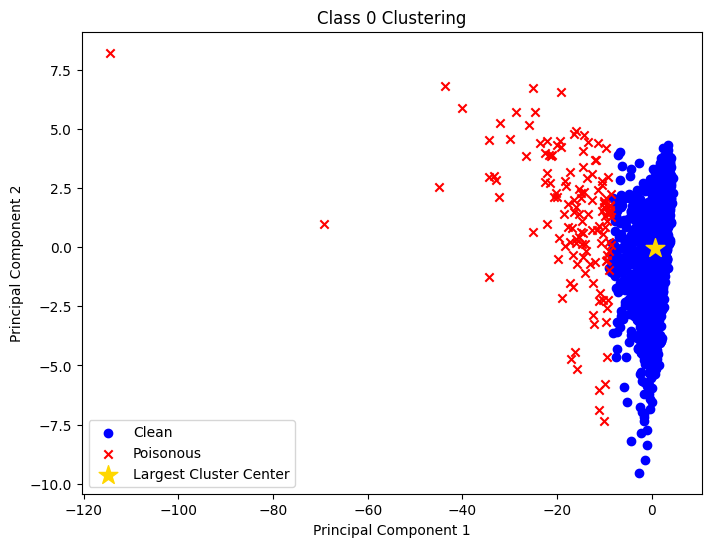

[class-1] silhouette_score = 0.653701 || ratio of 0.202528 
[class-2] silhouette_score = 0.171774 || ratio of 0.354642 
[class-3] silhouette_score = 0.657548 || ratio of 0.021543 
[class-4] silhouette_score = 0.154203 || ratio of 0.412206 
[class-5] silhouette_score = 0.165917 || ratio of 0.355928 
[class-6] silhouette_score = 0.628835 || ratio of 0.018307 
[class-7] silhouette_score = 0.953468 || ratio of 0.169420 


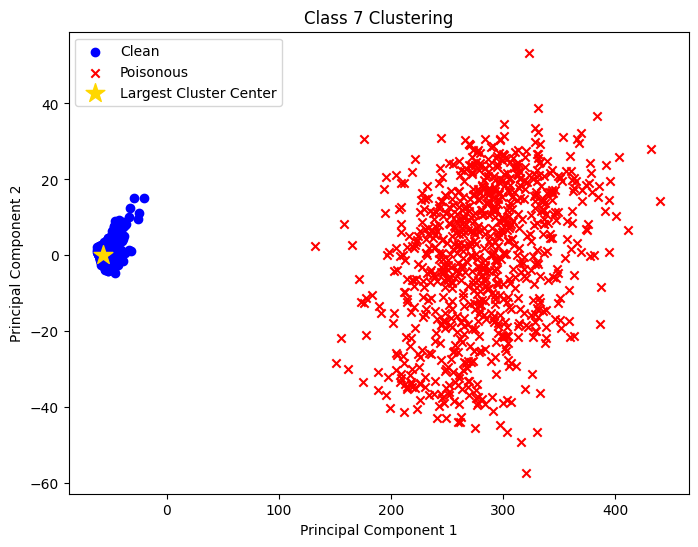

[class-8] silhouette_score = 0.676502 || ratio of 0.020187 
[class-9] silhouette_score = 0.686047 || ratio of 0.175669 
The poisoned class is:  7
Len of suspicious indices:  800
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 2
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:46<00:00, 21.51it/s]


[class-0] silhouette_score = 0.177028 || ratio of 0.431147 
[class-1] silhouette_score = 0.156718 || ratio of 0.468268 
[class-2] silhouette_score = 0.145774 || ratio of 0.475393 
[class-3] silhouette_score = 0.143299 || ratio of 0.473697 
[class-4] silhouette_score = 0.170565 || ratio of 0.490245 
[class-5] silhouette_score = 0.142057 || ratio of 0.431328 
[class-6] silhouette_score = 0.122535 || ratio of 0.497076 
[class-7] silhouette_score = 0.355677 || ratio of 0.186150 


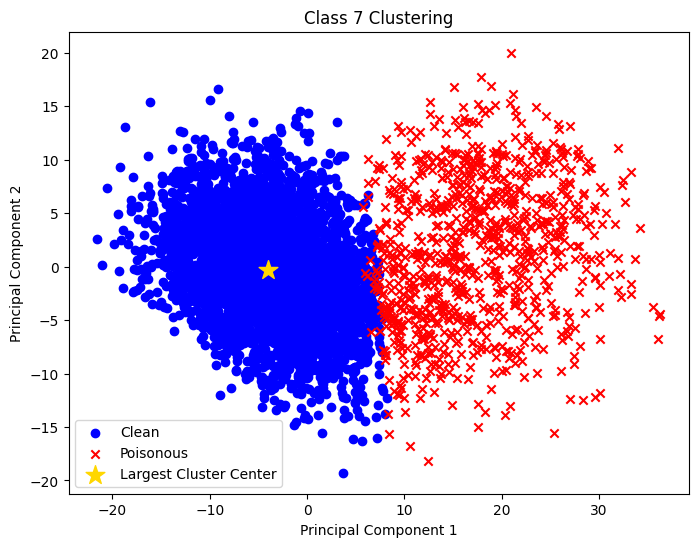

[class-8] silhouette_score = 0.186711 || ratio of 0.495332 
[class-9] silhouette_score = 0.161381 || ratio of 0.493185 
The poisoned class is:  7
Len of suspicious indices:  879
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 495
False Negatives: 16
False Positive Rate: 56.31%
False Negative Rate: 4.00%
Training for configuration ID: 3
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:45<00:00, 22.03it/s]


[class-0] silhouette_score = 0.179864 || ratio of 0.461442 
[class-1] silhouette_score = 0.159931 || ratio of 0.499368 
[class-2] silhouette_score = 0.156531 || ratio of 0.459411 
[class-3] silhouette_score = 0.165198 || ratio of 0.484469 
[class-4] silhouette_score = 0.180355 || ratio of 0.495998 
[class-5] silhouette_score = 0.147595 || ratio of 0.460015 
[class-6] silhouette_score = 0.157936 || ratio of 0.471142 
[class-7] silhouette_score = 0.834763 || ratio of 0.169208 


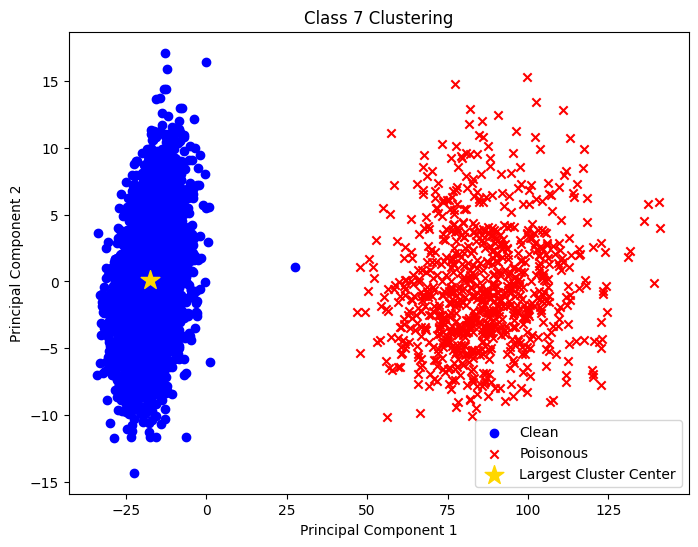

[class-8] silhouette_score = 0.163162 || ratio of 0.441080 
[class-9] silhouette_score = 0.148170 || ratio of 0.497476 
The poisoned class is:  7
Len of suspicious indices:  799
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 399
False Negatives: 0
False Positive Rate: 49.94%
False Negative Rate: 0.00%
Training for configuration ID: 4
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:46<00:00, 21.53it/s]


[class-0] silhouette_score = 0.184478 || ratio of 0.445168 
[class-1] silhouette_score = 0.166264 || ratio of 0.483186 
[class-2] silhouette_score = 0.156790 || ratio of 0.480974 
[class-3] silhouette_score = 0.163534 || ratio of 0.485972 
[class-4] silhouette_score = 0.162575 || ratio of 0.484992 
[class-5] silhouette_score = 0.150929 || ratio of 0.472963 
[class-6] silhouette_score = 0.153770 || ratio of 0.482838 
[class-7] silhouette_score = 0.482720 || ratio of 0.166878 


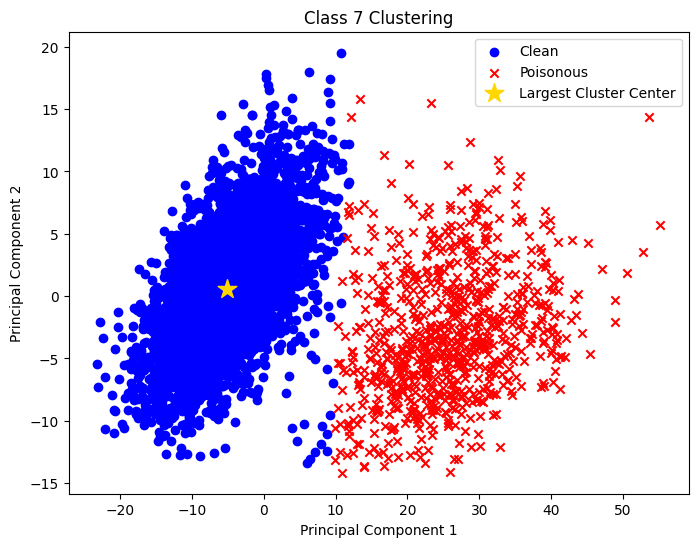

[class-8] silhouette_score = 0.173288 || ratio of 0.494070 
[class-9] silhouette_score = 0.154677 || ratio of 0.497728 
The poisoned class is:  7
Len of suspicious indices:  788
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 404
False Negatives: 16
False Positive Rate: 51.27%
False Negative Rate: 4.00%
Training for configuration ID: 5
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:46<00:00, 21.90it/s]


[class-0] silhouette_score = 0.141606 || ratio of 0.442664 
[class-1] silhouette_score = 0.142693 || ratio of 0.467762 
[class-2] silhouette_score = 0.140195 || ratio of 0.498732 
[class-3] silhouette_score = 0.140171 || ratio of 0.487976 
[class-4] silhouette_score = 0.163756 || ratio of 0.498999 
[class-5] silhouette_score = 0.147981 || ratio of 0.481087 
[class-6] silhouette_score = 0.143091 || ratio of 0.478261 
[class-7] silhouette_score = 0.505978 || ratio of 0.168996 


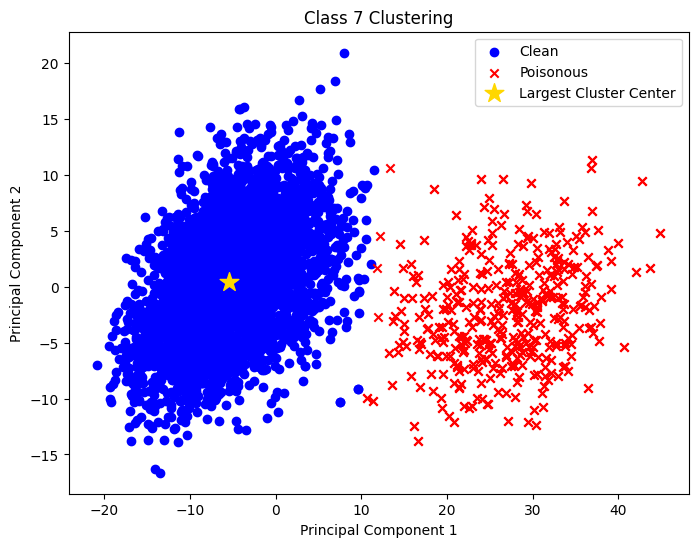

[class-8] silhouette_score = 0.165110 || ratio of 0.481453 
[class-9] silhouette_score = 0.142337 || ratio of 0.474003 
The poisoned class is:  7
Len of suspicious indices:  798
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 401
False Negatives: 3
False Positive Rate: 50.25%
False Negative Rate: 0.75%
Training for configuration ID: 6
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:45<00:00, 22.33it/s]


[class-0] silhouette_score = 0.174124 || ratio of 0.443916 
[class-1] silhouette_score = 0.182706 || ratio of 0.452592 
[class-2] silhouette_score = 0.141649 || ratio of 0.496702 
[class-3] silhouette_score = 0.143516 || ratio of 0.486473 
[class-4] silhouette_score = 0.171178 || ratio of 0.471736 
[class-5] silhouette_score = 0.162793 || ratio of 0.445545 
[class-6] silhouette_score = 0.130860 || ratio of 0.495042 
[class-7] silhouette_score = 0.327292 || ratio of 0.209445 


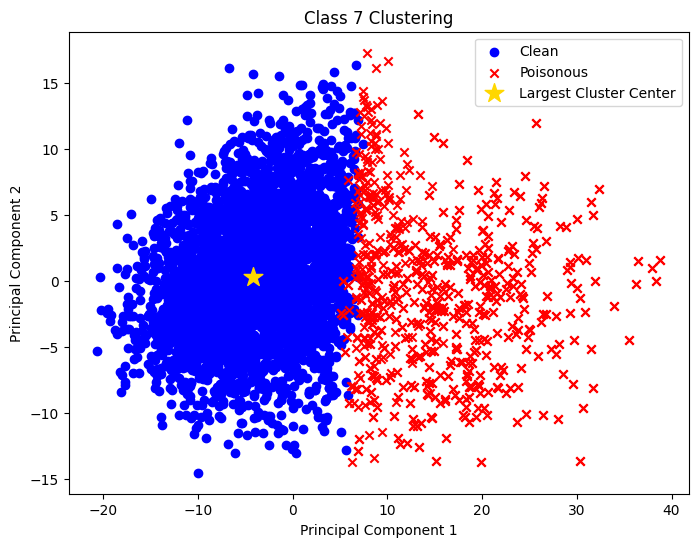

[class-8] silhouette_score = 0.147112 || ratio of 0.465304 
[class-9] silhouette_score = 0.161040 || ratio of 0.498738 
The poisoned class is:  7
Len of suspicious indices:  989
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 602
False Negatives: 13
False Positive Rate: 60.87%
False Negative Rate: 3.25%
Training for configuration ID: 7
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:43<00:00, 23.16it/s]


[class-0] silhouette_score = 0.184413 || ratio of 0.447672 
[class-1] silhouette_score = 0.172116 || ratio of 0.475095 
[class-2] silhouette_score = 0.163354 || ratio of 0.489853 
[class-3] silhouette_score = 0.153876 || ratio of 0.474950 
[class-4] silhouette_score = 0.168188 || ratio of 0.493747 
[class-5] silhouette_score = 0.151826 || ratio of 0.449860 
[class-6] silhouette_score = 0.152803 || ratio of 0.469362 
[class-7] silhouette_score = 0.378399 || ratio of 0.183397 


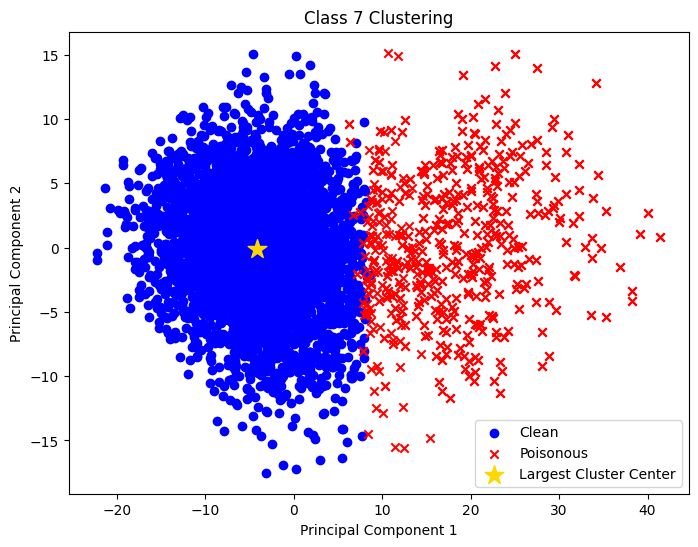

[class-8] silhouette_score = 0.185432 || ratio of 0.462781 
[class-9] silhouette_score = 0.153595 || ratio of 0.491923 
The poisoned class is:  7
Len of suspicious indices:  866
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 488
False Negatives: 22
False Positive Rate: 56.35%
False Negative Rate: 5.50%
Training for configuration ID: 8
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:46<00:00, 21.91it/s]


[class-0] silhouette_score = 0.172633 || ratio of 0.437406 
[class-1] silhouette_score = 0.154469 || ratio of 0.475095 
[class-2] silhouette_score = 0.157327 || ratio of 0.471081 
[class-3] silhouette_score = 0.167575 || ratio of 0.466934 
[class-4] silhouette_score = 0.172040 || ratio of 0.486243 
[class-5] silhouette_score = 0.166758 || ratio of 0.483879 
[class-6] silhouette_score = 0.152081 || ratio of 0.491991 
[class-7] silhouette_score = 0.404840 || ratio of 0.158407 


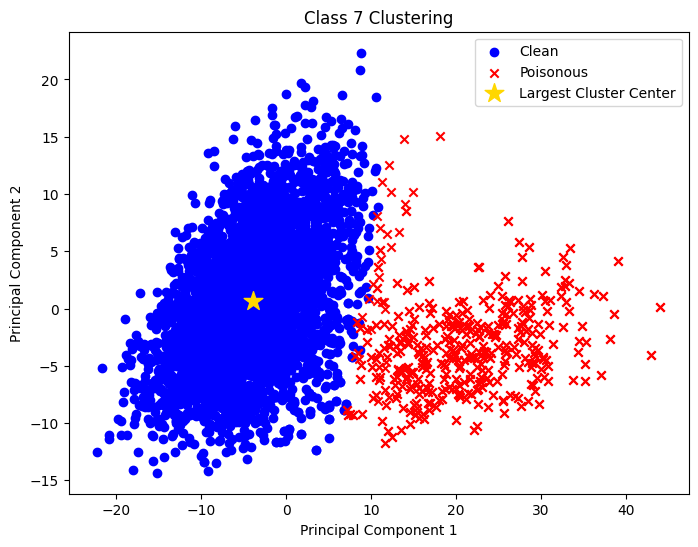

[class-8] silhouette_score = 0.188816 || ratio of 0.470351 
[class-9] silhouette_score = 0.159706 || ratio of 0.496719 
The poisoned class is:  7
Len of suspicious indices:  748
starting verification process
done with verification process
Length of patched indices:  400
False Positives: 387
False Negatives: 39
False Positive Rate: 51.74%
False Negative Rate: 9.75%


In [21]:
configurations = [
    {'test_number': 1, 'shape': 'Square', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
    {'test_number': 2, 'shape': 'Square', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
    {'test_number': 3, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
    {'test_number': 4, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
    {'test_number': 5, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
    {'test_number': 6, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
    {'test_number': 7, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
    {'test_number': 8, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 9, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 10, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 11, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 12, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 13, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 14, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 15, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 16, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 17, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 18, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 19, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 20, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 21, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 22, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 23, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 24, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
]

patch_1 = 'gtsrb-german-traffic-sign/Patches/patch_1.png'
patch_1_circle = 'gtsrb-german-traffic-sign/Patches/patch_1_circle.png'
patch_1_triangle = 'gtsrb-german-traffic-sign/Patches/patch_1_triangle.png'
patch_2= 'gtsrb-german-traffic-sign/Patches/patch_2.png'
patch_2_circle = 'gtsrb-german-traffic-sign/Patches/patch_2_circle.png'
patch_2_triangle = 'gtsrb-german-traffic-sign/Patches/patch_2_triangle.png'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transforming the Data ToTensor and Normalize it 


data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

DataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 40
num_workers=1
for config in configurations:
    # Extract the configuration details
    test_number = config['test_number']
    shape = config['shape']
    position_state = config['location']
    patch_coverage_percentage = config['coverage']
    pattern = config['pattern']
    
    # Map pattern to the appropriate patch path
    if pattern == 'patch_1':
        if shape=='Square':
            patch_path = patch_1  
        elif shape=='Circle':
            patch_path = patch_1_circle  
        elif shape=='Triangle':
            patch_path = patch_1_triangle  
    elif pattern == 'patch_2':
        if shape=='Square':
            patch_path = patch_2  
        elif shape=='Circle':
            patch_path = patch_2_circle  
        elif shape=='Triangle':
            patch_path = patch_2_triangle  
            
    print(f"Training for configuration ID: {test_number}")


    # Fix the random seed
    torch.manual_seed(42)

    trainset_full = datasets.CIFAR10(root='./data', train=True, download=False, transform=None)

    # Define the sizes for training and validation sets
    train_size = int(0.8 * len(trainset_full))
    validation_size = len(trainset_full) - train_size


    # Split the dataset
    train_dataset, validation_dataset = random_split(trainset_full, [train_size, validation_size])
#     print("Train dataset size: ",train_size)
#     print("Validation dataset size: ",validation_size)

    #TRAINING DATASET
    training_total_size = len(train_dataset)
    training_patched_size = int(training_total_size * 0.01)  # 50% of the dataset to be patched
    training_indices = torch.randperm(training_total_size).tolist()
    training_patched_indices = training_indices[:training_patched_size]

#     print("length of all training images: ",len(training_indices))
#     print("length of backdoored training images: ",len(training_patched_indices))

    # Example usage, assuming all other variables are defined as before
    target_label = 7  # The new label for all patched images

    training_patched_trainset = CIFAR10BackdooredTraining(datasets=train_dataset, train=True, download=True, transform=data_transforms_train,
                                        patch_path=patch_path,patch_coverage_percentage=patch_coverage_percentage,
                                        position_state=position_state,
                                          patched_indices=training_patched_indices, target_label=target_label)

    Trainloader = DataLoader(training_patched_trainset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    
#     show_patched_images(training_patched_trainset, training_patched_indices, num_images=4)

    #VALIDATION DATASET
    validation_total_size = len(validation_dataset)
    validation_patched_size = int(validation_total_size * 0.01)  # 50% of the dataset to be patched
    validation_indices = torch.randperm(validation_total_size).tolist()
    validation_patched_indices = validation_indices[:validation_patched_size]

#     print("length of all validation images: ",len(validation_indices))
#     print("length of backdoored validation images: ",len(validation_patched_indices))

    #BACKDOORED 
    BackdooredValidationSet = CIFAR10_Test_Backoored(validation_dataset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=validation_patched_indices, target_label=target_label)

    BackdooredValidationloader = DataLoader(BackdooredValidationSet, batch_size=40, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    CleanValidationset =CIFAR10_Test_Clean(validation_dataset,transform=DataTransform, exclude_indices=validation_patched_indices)

    CleanValidationloader = DataLoader(CleanValidationset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    ####TESTING DATASET
    # Load the full CIFAR-10 train dataset
    test_full_trainset = datasets.CIFAR10(root='./data', train=False,
                                     download=False, transform=None)

    test_total_size = len(test_full_trainset)
    test_patched_size = int(test_total_size * 0.04)  # 50% of the dataset to be patched
    test_indices = torch.randperm(test_total_size).tolist()
    test_patched_indices = test_indices[:test_patched_size]

    ##BACKDOORED 
    testing_patched_testset = CIFAR10_Test_Backoored(test_full_trainset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=test_patched_indices, target_label=target_label)

    backdooredTestloader = DataLoader(testing_patched_testset, batch_size=4, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    clean_testset = CIFAR10_Test_Clean(test_full_trainset,transform=DataTransform, exclude_indices=test_patched_indices)

    Cleantestloader = DataLoader(clean_testset, batch_size=4, shuffle=True, num_workers=num_workers)
    print("length of clean test images: ",len(Cleantestloader.dataset))
    print("length of backdoored test images: ",len(backdooredTestloader.dataset))
    
#     show_images(BackdooredValidationloader,CleanValidationloader,backdooredTestloader)


    num_classes = 10  # The number of output classes in your trained model
    model = resnet50(weights=None)  # Load the model without pretrained weights
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the fully connected layer
    model_path=f"Cifar_Models/Cifar_resnet50_epochs2_{test_number}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    dataloaders = {'training':Trainloader,"clean": CleanValidationloader, "backdoor": BackdooredValidationloader}
    dataset_sizes = {'training':len(Trainloader.dataset), "clean": len(CleanValidationloader.dataset), "backdoor": len(BackdooredValidationloader.dataset)}
    print(dataset_sizes)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    most_suspicious_class,suspicious_indices = cleanser(Trainloader, model, num_classes, device,verify_suspicious_indices)
    print("Len of suspicious indices: ",len(suspicious_indices))

    verify_suspicious_indices(Trainloader.dataset, suspicious_indices, most_suspicious_class)
    calculate_fp_fn_cifar(Trainloader, suspicious_indices, most_suspicious_class)

    

#         # Initialize the model
#     model = resnet50(weights=None, num_classes=10).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     num_epochs = 100
#     out_path = f"Cifar_Models/Cifar_resnet50_epochs2_{test_number}.pt"



# #     Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_file_name = f"CIFAR_plots/plot_of_config_{test_number}.png"
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc,plot_file_name)
#     print('Best validation Accuracy:', best_acc)
#     print('Best validation Accuracy:', best_acc)
#     test_clean(model,Cleantestloader,device)
#     test_backdoored(model,backdooredTestloader,device)
    


## Training again from scratch patch 5 and 6 old metrics

Training for configuration ID: 1
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.22it/s]


[class-0] silhouette_score = 0.182520 || ratio of 0.495493 
[class-1] silhouette_score = 0.180431 || ratio of 0.480657 
[class-2] silhouette_score = 0.139830 || ratio of 0.443430 
[class-3] silhouette_score = 0.182495 || ratio of 0.415080 
[class-4] silhouette_score = 0.186422 || ratio of 0.417209 
[class-5] silhouette_score = 0.161780 || ratio of 0.436405 
[class-6] silhouette_score = 0.168373 || ratio of 0.475718 
[class-7] silhouette_score = 0.399879 || ratio of 0.169420 


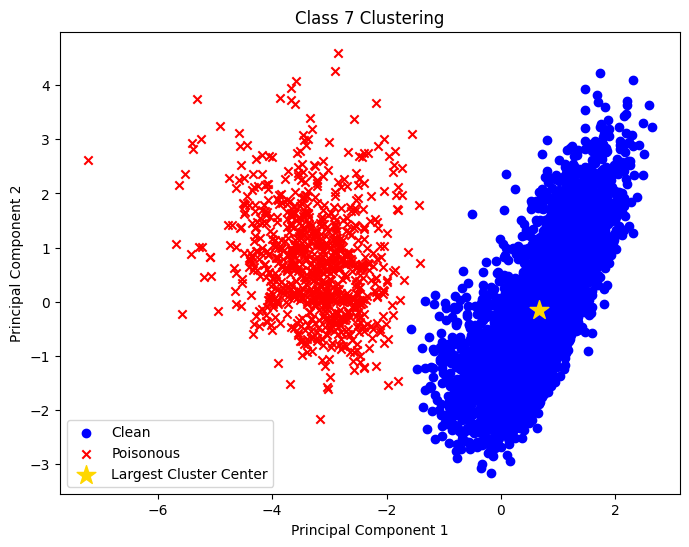

[class-8] silhouette_score = 0.192467 || ratio of 0.472874 
[class-9] silhouette_score = 0.187698 || ratio of 0.492933 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 2
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.92it/s]


[class-0] silhouette_score = 0.169587 || ratio of 0.487982 
[class-1] silhouette_score = 0.160647 || ratio of 0.499115 
[class-2] silhouette_score = 0.182343 || ratio of 0.396499 


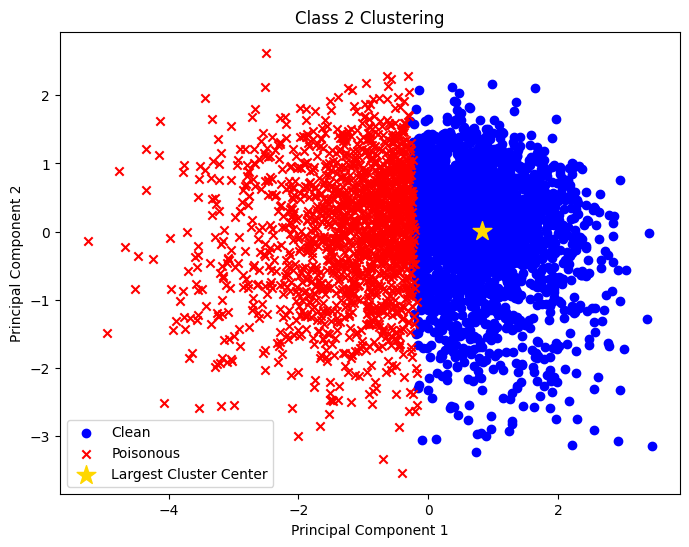

[class-3] silhouette_score = 0.179229 || ratio of 0.412575 
[class-4] silhouette_score = 0.195325 || ratio of 0.414707 
[class-5] silhouette_score = 0.150093 || ratio of 0.442244 
[class-6] silhouette_score = 0.169879 || ratio of 0.473938 
[class-7] silhouette_score = 0.460367 || ratio of 0.168784 


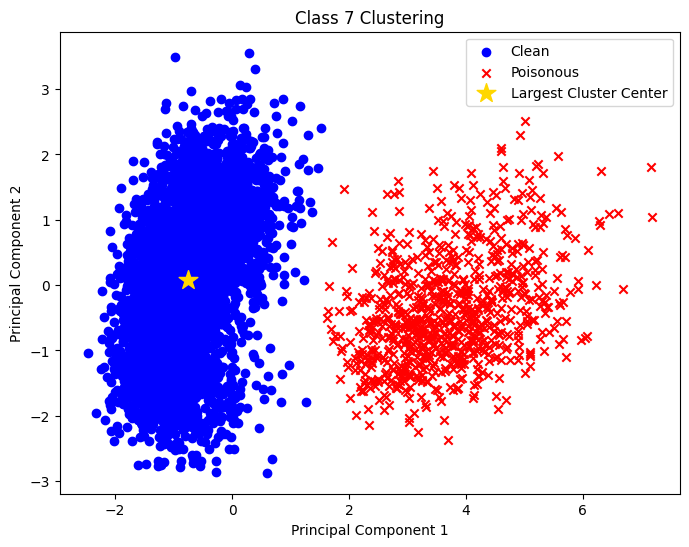

[class-8] silhouette_score = 0.195959 || ratio of 0.480444 
[class-9] silhouette_score = 0.192886 || ratio of 0.486371 
The poisoned class is:  7
Len of suspicious indices:  797
Length of patched indices:  400
False Positives: 399
False Negatives: 2
False Positive Rate: 50.06%
False Negative Rate: 0.50%
Training for configuration ID: 3
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.13it/s]


[class-0] silhouette_score = 0.173667 || ratio of 0.474211 
[class-1] silhouette_score = 0.163763 || ratio of 0.471808 
[class-2] silhouette_score = 0.164883 || ratio of 0.415271 
[class-3] silhouette_score = 0.190722 || ratio of 0.409068 
[class-4] silhouette_score = 0.196271 || ratio of 0.408704 
[class-5] silhouette_score = 0.162642 || ratio of 0.425489 
[class-6] silhouette_score = 0.178630 || ratio of 0.474701 
[class-7] silhouette_score = 0.439310 || ratio of 0.167302 


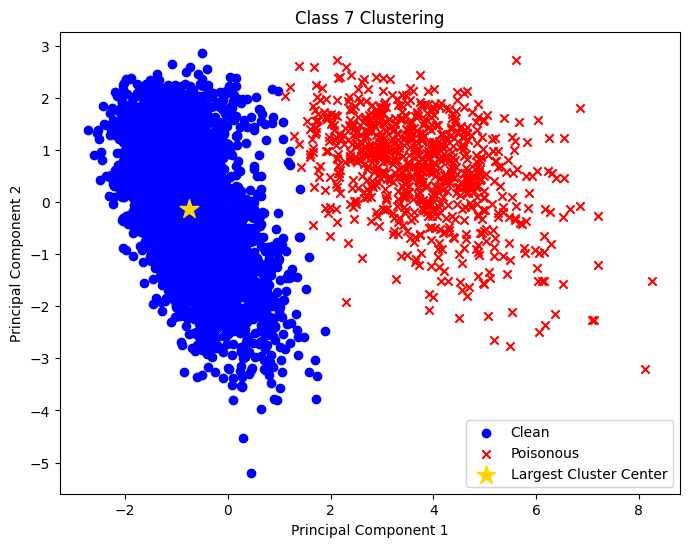

[class-8] silhouette_score = 0.194201 || ratio of 0.498360 
[class-9] silhouette_score = 0.171866 || ratio of 0.484351 
The poisoned class is:  7
Len of suspicious indices:  790
Length of patched indices:  400
False Positives: 396
False Negatives: 6
False Positive Rate: 50.13%
False Negative Rate: 1.50%
Training for configuration ID: 4
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.96it/s]


[class-0] silhouette_score = 0.170022 || ratio of 0.477216 
[class-1] silhouette_score = 0.179613 || ratio of 0.454614 
[class-2] silhouette_score = 0.149584 || ratio of 0.436073 
[class-3] silhouette_score = 0.178513 || ratio of 0.409820 
[class-4] silhouette_score = 0.190586 || ratio of 0.399700 


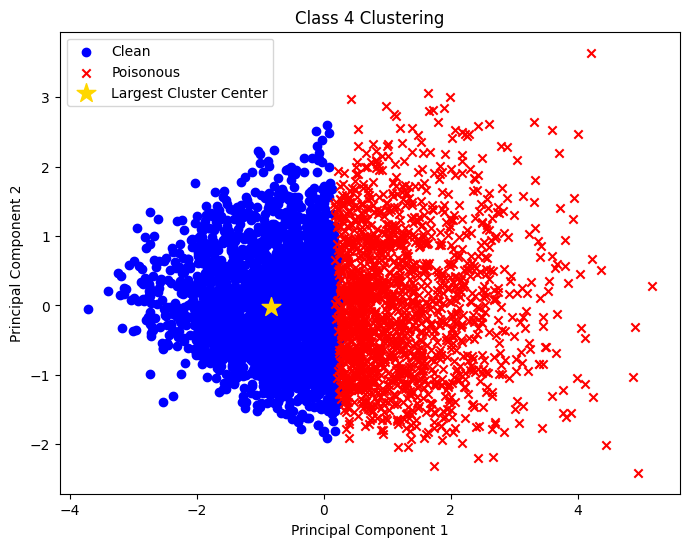

[class-5] silhouette_score = 0.132685 || ratio of 0.459507 
[class-6] silhouette_score = 0.164326 || ratio of 0.469362 
[class-7] silhouette_score = 0.404586 || ratio of 0.168361 


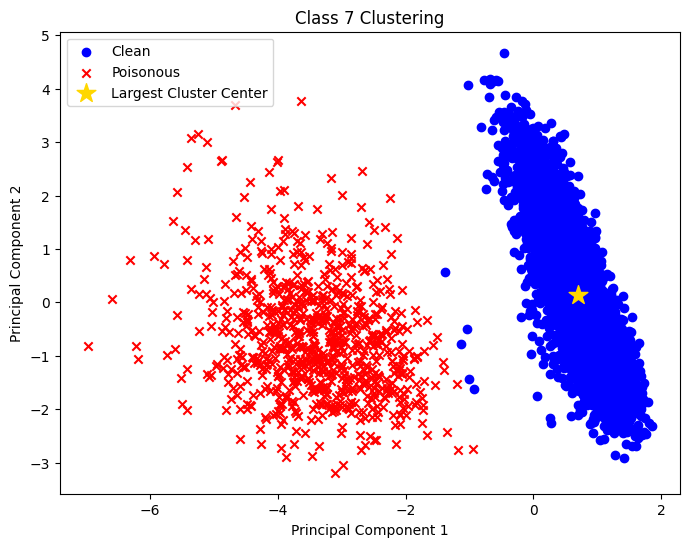

[class-8] silhouette_score = 0.213084 || ratio of 0.472117 
[class-9] silhouette_score = 0.177011 || ratio of 0.495962 
The poisoned class is:  7
Len of suspicious indices:  795
Length of patched indices:  400
False Positives: 396
False Negatives: 1
False Positive Rate: 49.81%
False Negative Rate: 0.25%
Training for configuration ID: 5
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.30it/s]


[class-0] silhouette_score = 0.170750 || ratio of 0.452929 
[class-1] silhouette_score = 0.170104 || ratio of 0.498862 
[class-2] silhouette_score = 0.188738 || ratio of 0.387367 


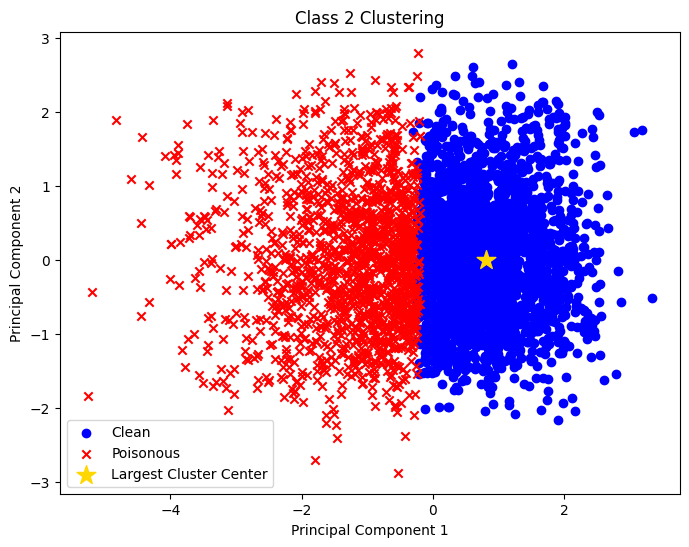

[class-3] silhouette_score = 0.194941 || ratio of 0.432114 
[class-4] silhouette_score = 0.188359 || ratio of 0.466983 
[class-5] silhouette_score = 0.148361 || ratio of 0.451384 
[class-6] silhouette_score = 0.180977 || ratio of 0.472413 
[class-7] silhouette_score = 0.392668 || ratio of 0.170267 


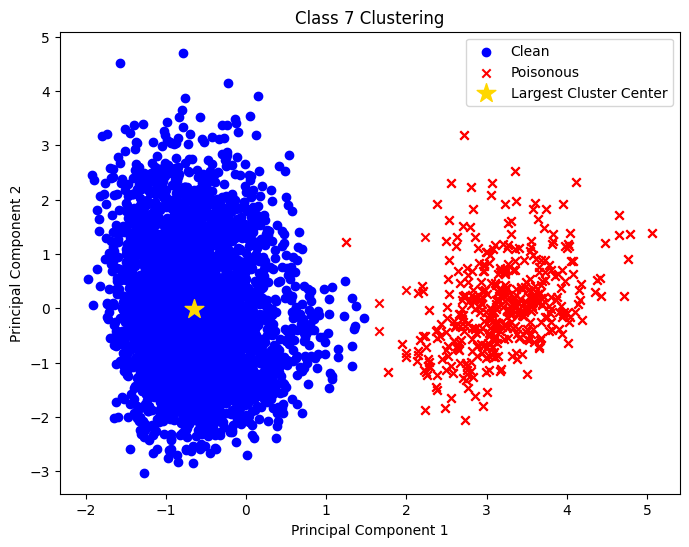

[class-8] silhouette_score = 0.204988 || ratio of 0.459500 
[class-9] silhouette_score = 0.172210 || ratio of 0.488390 
The poisoned class is:  7
Len of suspicious indices:  804
Length of patched indices:  400
False Positives: 404
False Negatives: 0
False Positive Rate: 50.25%
False Negative Rate: 0.00%
Training for configuration ID: 6
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.29it/s]


[class-0] silhouette_score = 0.161363 || ratio of 0.485228 
[class-1] silhouette_score = 0.173709 || ratio of 0.497092 
[class-2] silhouette_score = 0.150141 || ratio of 0.433283 
[class-3] silhouette_score = 0.191469 || ratio of 0.415832 
[class-4] silhouette_score = 0.190037 || ratio of 0.412456 
[class-5] silhouette_score = 0.147471 || ratio of 0.468139 
[class-6] silhouette_score = 0.173907 || ratio of 0.468599 
[class-7] silhouette_score = 0.349445 || ratio of 0.169420 


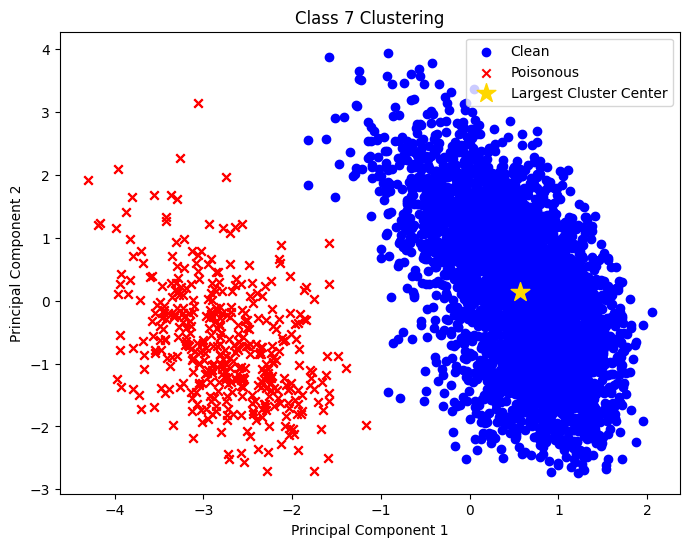

[class-8] silhouette_score = 0.208748 || ratio of 0.467575 
[class-9] silhouette_score = 0.177338 || ratio of 0.499748 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 7
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.91it/s]


[class-0] silhouette_score = 0.181462 || ratio of 0.491237 
[class-1] silhouette_score = 0.168163 || ratio of 0.484450 
[class-2] silhouette_score = 0.142349 || ratio of 0.493151 
[class-3] silhouette_score = 0.180850 || ratio of 0.445892 
[class-4] silhouette_score = 0.196239 || ratio of 0.487494 
[class-5] silhouette_score = 0.160423 || ratio of 0.463062 
[class-6] silhouette_score = 0.172817 || ratio of 0.490720 
[class-7] silhouette_score = 0.433314 || ratio of 0.169420 


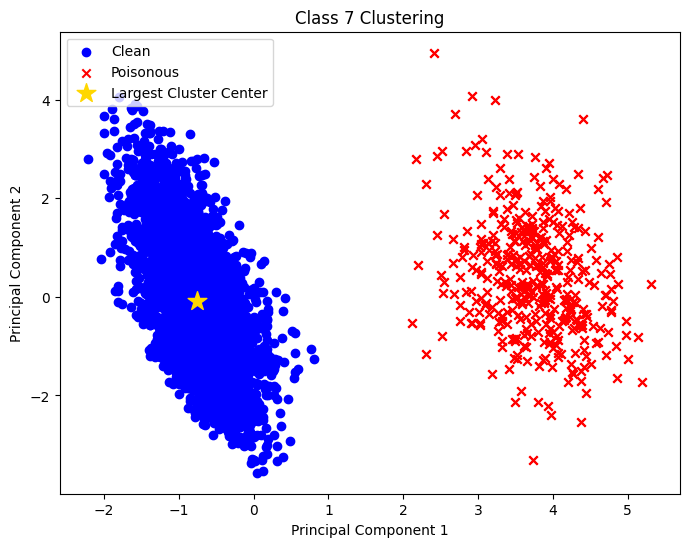

[class-8] silhouette_score = 0.220491 || ratio of 0.458996 
[class-9] silhouette_score = 0.157745 || ratio of 0.485361 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 8
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.51it/s]


[class-0] silhouette_score = 0.172635 || ratio of 0.457687 
[class-1] silhouette_score = 0.164538 || ratio of 0.487990 
[class-2] silhouette_score = 0.156091 || ratio of 0.497971 
[class-3] silhouette_score = 0.185860 || ratio of 0.434870 
[class-4] silhouette_score = 0.176824 || ratio of 0.476238 
[class-5] silhouette_score = 0.166634 || ratio of 0.435644 
[class-6] silhouette_score = 0.169798 || ratio of 0.498093 
[class-7] silhouette_score = 0.495149 || ratio of 0.169420 


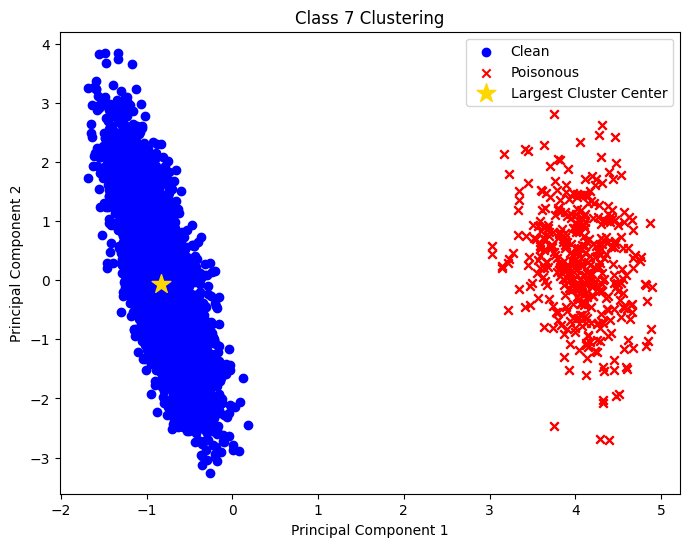

[class-8] silhouette_score = 0.202305 || ratio of 0.491547 
[class-9] silhouette_score = 0.172952 || ratio of 0.499243 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%


In [72]:
configurations = [
    {'test_number': 1, 'shape': 'Square', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
    {'test_number': 2, 'shape': 'Square', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
    {'test_number': 3, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
    {'test_number': 4, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
    {'test_number': 5, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
    {'test_number': 6, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
    {'test_number': 7, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
    {'test_number': 8, 'shape': 'Square', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 9, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 10, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 11, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 12, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 13, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 14, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 15, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 16, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 17, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 18, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 19, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 20, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 21, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 22, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 23, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 24, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
]

patch_1 = 'gtsrb-german-traffic-sign/Patches/patch_5.png'
patch_1_circle = 'gtsrb-german-traffic-sign/Patches/patch_1_circle.png'
patch_1_triangle = 'gtsrb-german-traffic-sign/Patches/patch_1_triangle.png'
patch_2= 'gtsrb-german-traffic-sign/Patches/patch_6.png'
patch_2_circle = 'gtsrb-german-traffic-sign/Patches/patch_2_circle.png'
patch_2_triangle = 'gtsrb-german-traffic-sign/Patches/patch_2_triangle.png'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transforming the Data ToTensor and Normalize it 


data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

DataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 40
num_workers=1
for config in configurations:
    # Extract the configuration details
    test_number = config['test_number']
    shape = config['shape']
    position_state = config['location']
    patch_coverage_percentage = config['coverage']
    pattern = config['pattern']
    
    # Map pattern to the appropriate patch path
    if pattern == 'patch_1':
        if shape=='Square':
            patch_path = patch_1  
        elif shape=='Circle':
            patch_path = patch_1_circle  
        elif shape=='Triangle':
            patch_path = patch_1_triangle  
    elif pattern == 'patch_2':
        if shape=='Square':
            patch_path = patch_2  
        elif shape=='Circle':
            patch_path = patch_2_circle  
        elif shape=='Triangle':
            patch_path = patch_2_triangle  
            
    print(f"Training for configuration ID: {test_number}")


    # Fix the random seed
    torch.manual_seed(42)

    trainset_full = datasets.CIFAR10(root='./data', train=True, download=False, transform=None)

    # Define the sizes for training and validation sets
    train_size = int(0.8 * len(trainset_full))
    validation_size = len(trainset_full) - train_size


    # Split the dataset
    train_dataset, validation_dataset = random_split(trainset_full, [train_size, validation_size])

    #TRAINING DATASET
    training_total_size = len(train_dataset)
    training_patched_size = int(training_total_size * 0.01)  # 50% of the dataset to be patched
    training_indices = torch.randperm(training_total_size).tolist()
    training_patched_indices = training_indices[:training_patched_size]

    target_label = 7  # The new label for all patched images

    training_patched_trainset = CIFAR10BackdooredTraining(datasets=train_dataset, train=True, download=True, transform=data_transforms_train,
                                        patch_path=patch_path,patch_coverage_percentage=patch_coverage_percentage,
                                        position_state=position_state,
                                          patched_indices=training_patched_indices, target_label=target_label)

    Trainloader = DataLoader(training_patched_trainset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    
#     show_patched_images(training_patched_trainset, training_patched_indices, num_images=4)

    #VALIDATION DATASET
    validation_total_size = len(validation_dataset)
    validation_patched_size = int(validation_total_size * 0.01)  # 50% of the dataset to be patched
    validation_indices = torch.randperm(validation_total_size).tolist()
    validation_patched_indices = validation_indices[:validation_patched_size]

#     print("length of all validation images: ",len(validation_indices))
#     print("length of backdoored validation images: ",len(validation_patched_indices))

    #BACKDOORED 
    BackdooredValidationSet = CIFAR10_Test_Backoored(validation_dataset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=validation_patched_indices, target_label=target_label)

    BackdooredValidationloader = DataLoader(BackdooredValidationSet, batch_size=40, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    CleanValidationset =CIFAR10_Test_Clean(validation_dataset,transform=DataTransform, exclude_indices=validation_patched_indices)

    CleanValidationloader = DataLoader(CleanValidationset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    ####TESTING DATASET
    # Load the full CIFAR-10 train dataset
    test_full_trainset = datasets.CIFAR10(root='./data', train=False,
                                     download=False, transform=None)

    test_total_size = len(test_full_trainset)
    test_patched_size = int(test_total_size * 0.04)  # 50% of the dataset to be patched
    test_indices = torch.randperm(test_total_size).tolist()
    test_patched_indices = test_indices[:test_patched_size]

    ##BACKDOORED 
    testing_patched_testset = CIFAR10_Test_Backoored(test_full_trainset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=test_patched_indices, target_label=target_label)

    backdooredTestloader = DataLoader(testing_patched_testset, batch_size=4, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    clean_testset = CIFAR10_Test_Clean(test_full_trainset,transform=DataTransform, exclude_indices=test_patched_indices)

    Cleantestloader = DataLoader(clean_testset, batch_size=4, shuffle=True, num_workers=num_workers)
    print("length of clean test images: ",len(Cleantestloader.dataset))
    print("length of backdoored test images: ",len(backdooredTestloader.dataset))
    
#     show_images(BackdooredValidationloader,CleanValidationloader,backdooredTestloader)


    num_classes = 10  # The number of output classes in your trained model
    model = resnet50(weights=None)  # Load the model without pretrained weights
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the fully connected layer
    model_path=f"Cifar_Models/Trial_Cifar_resnet50_epochs100_{test_number}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    dataloaders = {'training':Trainloader,"clean": CleanValidationloader, "backdoor": BackdooredValidationloader}
    dataset_sizes = {'training':len(Trainloader.dataset), "clean": len(CleanValidationloader.dataset), "backdoor": len(BackdooredValidationloader.dataset)}
    print(dataset_sizes)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    most_suspicious_class,suspicious_indices = cleanser(Trainloader, model, num_classes, device,verify_suspicious_indices)
    print("Len of suspicious indices: ",len(suspicious_indices))

#     verify_suspicious_indices(Trainloader.dataset, suspicious_indices, most_suspicious_class)
    calculate_fp_fn_cifar(Trainloader, suspicious_indices, most_suspicious_class)

    

#         # Initialize the model
#     model = resnet50(weights=None, num_classes=10).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     num_epochs = 100
#     out_path = f"Cifar_Models/Cifar_resnet50_epochs2_{test_number}.pt"



# #     Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_file_name = f"CIFAR_plots/plot_of_config_{test_number}.png"
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc,plot_file_name)
#     print('Best validation Accuracy:', best_acc)
#     print('Best validation Accuracy:', best_acc)
#     test_clean(model,Cleantestloader,device)
#     test_backdoored(model,backdooredTestloader,device)
    

## Training again from scratch patch 5 and 6 new area metrics

Training for configuration ID: 1
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:43<00:00, 23.46it/s]


[class-0] silhouette_score = 0.152674 || ratio of 0.442163 
[class-1] silhouette_score = 0.180265 || ratio of 0.487231 
[class-2] silhouette_score = 0.151190 || ratio of 0.386352 


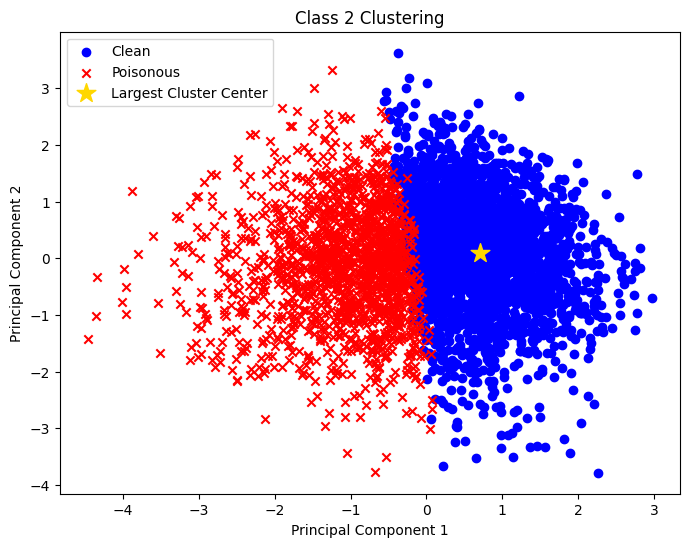

[class-3] silhouette_score = 0.184415 || ratio of 0.439128 
[class-4] silhouette_score = 0.184032 || ratio of 0.406203 
[class-5] silhouette_score = 0.159419 || ratio of 0.428027 
[class-6] silhouette_score = 0.167797 || ratio of 0.465039 
[class-7] silhouette_score = 0.294349 || ratio of 0.170055 


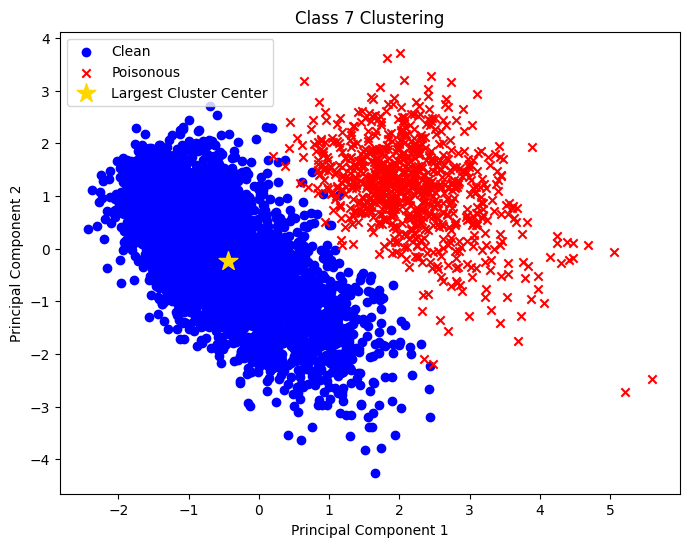

[class-8] silhouette_score = 0.176392 || ratio of 0.496593 
[class-9] silhouette_score = 0.175991 || ratio of 0.466683 
The poisoned class is:  7
Len of suspicious indices:  803
Length of patched indices:  400
False Positives: 403
False Negatives: 0
False Positive Rate: 50.19%
False Negative Rate: 0.00%
Training for configuration ID: 2
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.88it/s]


[class-0] silhouette_score = 0.162283 || ratio of 0.467952 
[class-1] silhouette_score = 0.173092 || ratio of 0.414665 
[class-2] silhouette_score = 0.180062 || ratio of 0.384323 


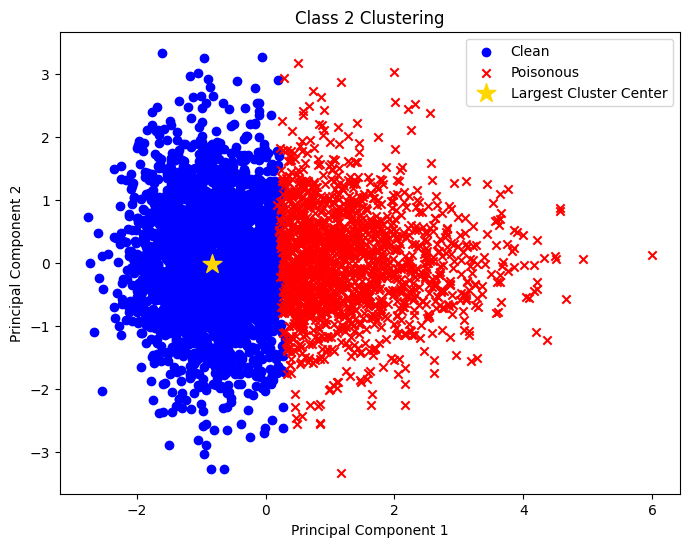

[class-3] silhouette_score = 0.177601 || ratio of 0.395541 
[class-4] silhouette_score = 0.189414 || ratio of 0.410455 
[class-5] silhouette_score = 0.144547 || ratio of 0.464585 
[class-6] silhouette_score = 0.166819 || ratio of 0.474447 
[class-7] silhouette_score = 0.396019 || ratio of 0.169843 


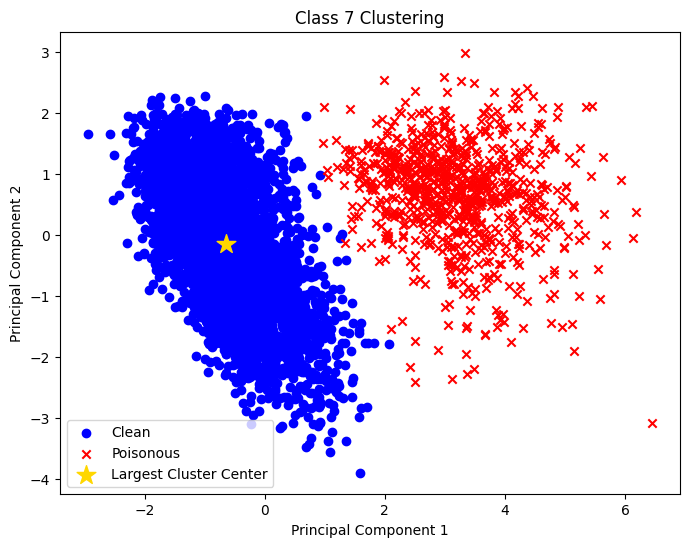

[class-8] silhouette_score = 0.208305 || ratio of 0.449407 
[class-9] silhouette_score = 0.149257 || ratio of 0.487633 
The poisoned class is:  7
Len of suspicious indices:  802
Length of patched indices:  400
False Positives: 402
False Negatives: 0
False Positive Rate: 50.12%
False Negative Rate: 0.00%
Training for configuration ID: 3
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.89it/s]


[class-0] silhouette_score = 0.173638 || ratio of 0.473460 
[class-1] silhouette_score = 0.163805 || ratio of 0.471049 
[class-2] silhouette_score = 0.164727 || ratio of 0.416032 
[class-3] silhouette_score = 0.191116 || ratio of 0.406814 
[class-4] silhouette_score = 0.196330 || ratio of 0.408454 
[class-5] silhouette_score = 0.162729 || ratio of 0.424981 
[class-6] silhouette_score = 0.178630 || ratio of 0.474701 
[class-7] silhouette_score = 0.439310 || ratio of 0.167302 


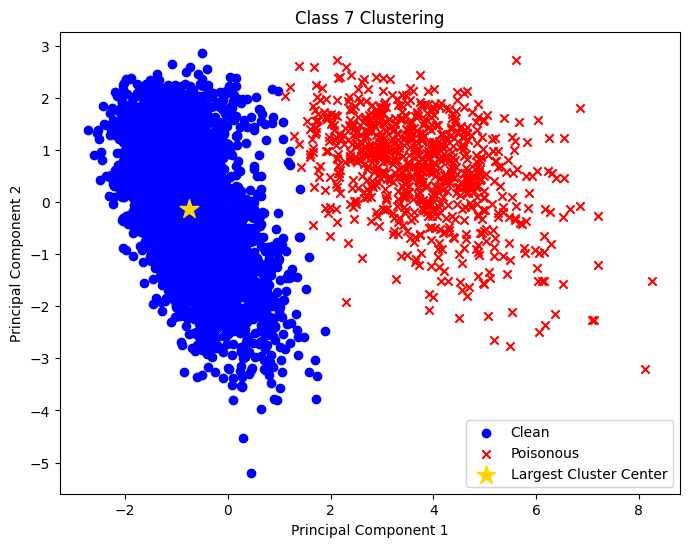

[class-8] silhouette_score = 0.194910 || ratio of 0.490790 
[class-9] silhouette_score = 0.171873 || ratio of 0.484099 
The poisoned class is:  7
Len of suspicious indices:  790
Length of patched indices:  400
False Positives: 396
False Negatives: 6
False Positive Rate: 50.13%
False Negative Rate: 1.50%
Training for configuration ID: 4
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.86it/s]


[class-0] silhouette_score = 0.161743 || ratio of 0.441412 
[class-1] silhouette_score = 0.160925 || ratio of 0.499621 
[class-2] silhouette_score = 0.143576 || ratio of 0.419330 
[class-3] silhouette_score = 0.192531 || ratio of 0.414830 
[class-4] silhouette_score = 0.176408 || ratio of 0.427964 
[class-5] silhouette_score = 0.138402 || ratio of 0.461031 
[class-6] silhouette_score = 0.165566 || ratio of 0.479278 
[class-7] silhouette_score = 0.463495 || ratio of 0.168149 


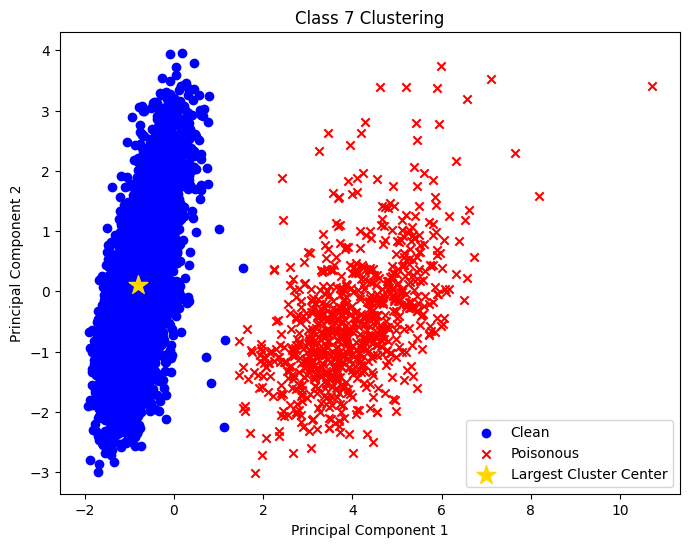

[class-8] silhouette_score = 0.190954 || ratio of 0.480444 
[class-9] silhouette_score = 0.152764 || ratio of 0.488894 
The poisoned class is:  7
Len of suspicious indices:  794
Length of patched indices:  400
False Positives: 398
False Negatives: 4
False Positive Rate: 50.13%
False Negative Rate: 1.00%
Training for configuration ID: 5
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.24it/s]


[class-0] silhouette_score = 0.162222 || ratio of 0.480721 
[class-1] silhouette_score = 0.181066 || ratio of 0.441972 
[class-2] silhouette_score = 0.152388 || ratio of 0.411466 
[class-3] silhouette_score = 0.188113 || ratio of 0.420591 
[class-4] silhouette_score = 0.193934 || ratio of 0.437969 
[class-5] silhouette_score = 0.156974 || ratio of 0.451130 
[class-6] silhouette_score = 0.158530 || ratio of 0.460208 
[class-7] silhouette_score = 0.311630 || ratio of 0.174502 


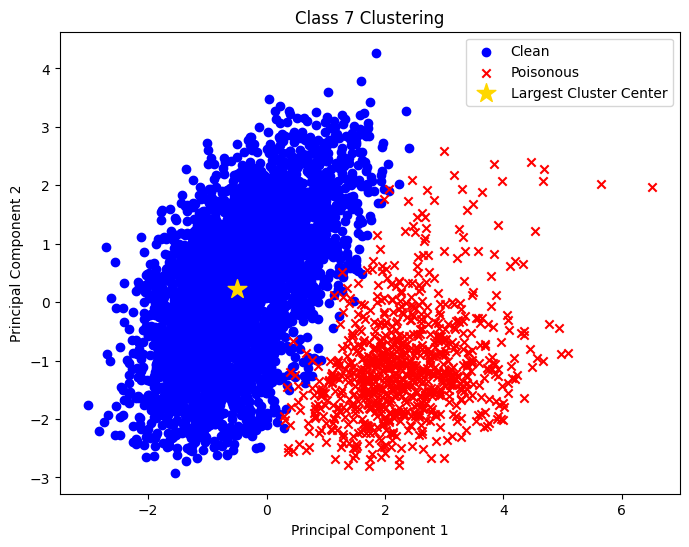

[class-8] silhouette_score = 0.195321 || ratio of 0.498360 
[class-9] silhouette_score = 0.167463 || ratio of 0.496719 
The poisoned class is:  7
Len of suspicious indices:  824
Length of patched indices:  400
False Positives: 427
False Negatives: 3
False Positive Rate: 51.82%
False Negative Rate: 0.75%
Training for configuration ID: 6
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.46it/s]


[class-0] silhouette_score = 0.173272 || ratio of 0.469204 
[class-1] silhouette_score = 0.191481 || ratio of 0.497851 
[class-2] silhouette_score = 0.159759 || ratio of 0.410452 
[class-3] silhouette_score = 0.169962 || ratio of 0.417585 
[class-4] silhouette_score = 0.189408 || ratio of 0.397449 


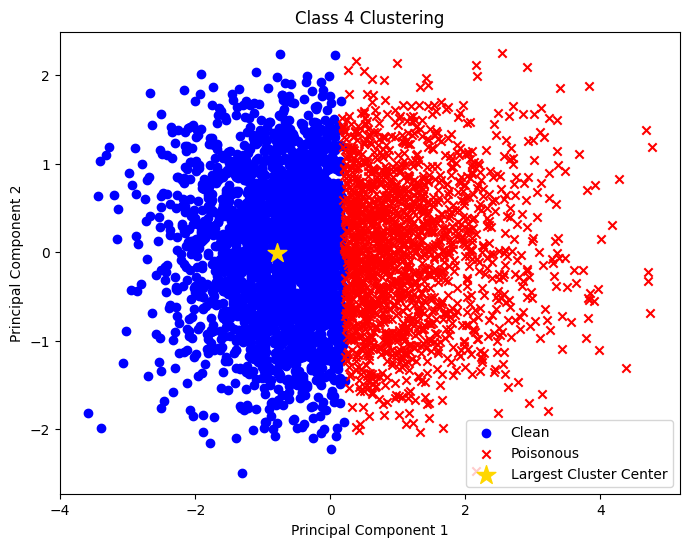

[class-5] silhouette_score = 0.154344 || ratio of 0.441736 
[class-6] silhouette_score = 0.167750 || ratio of 0.450547 
[class-7] silhouette_score = 0.519913 || ratio of 0.168149 


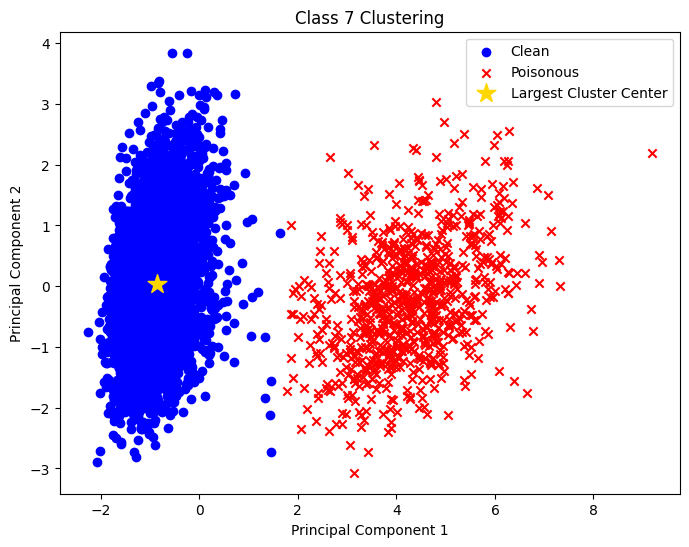

[class-8] silhouette_score = 0.203892 || ratio of 0.464547 
[class-9] silhouette_score = 0.189740 || ratio of 0.487128 
The poisoned class is:  7
Len of suspicious indices:  794
Length of patched indices:  400
False Positives: 398
False Negatives: 4
False Positive Rate: 50.13%
False Negative Rate: 1.00%
Training for configuration ID: 7
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.10it/s]


[class-0] silhouette_score = 0.170022 || ratio of 0.477216 
[class-1] silhouette_score = 0.179605 || ratio of 0.454867 
[class-2] silhouette_score = 0.149659 || ratio of 0.437341 
[class-3] silhouette_score = 0.178513 || ratio of 0.409820 
[class-4] silhouette_score = 0.190618 || ratio of 0.399450 


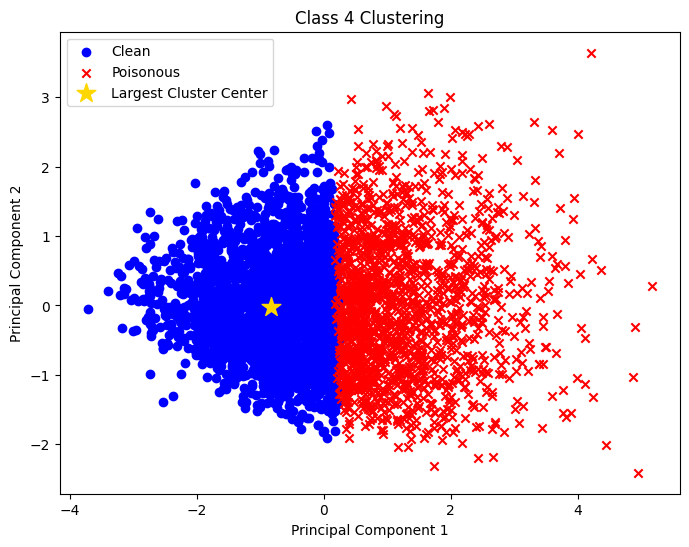

[class-5] silhouette_score = 0.132894 || ratio of 0.457730 
[class-6] silhouette_score = 0.164326 || ratio of 0.469362 
[class-7] silhouette_score = 0.404586 || ratio of 0.168361 


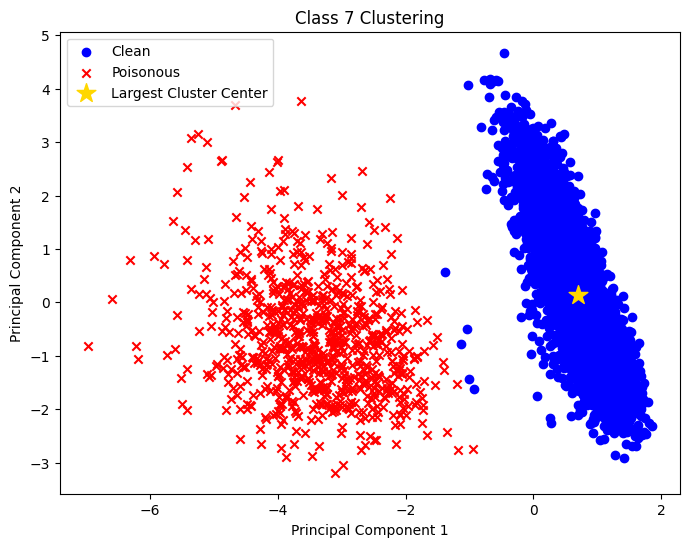

[class-8] silhouette_score = 0.213331 || ratio of 0.469846 
[class-9] silhouette_score = 0.177101 || ratio of 0.494700 
The poisoned class is:  7
Len of suspicious indices:  795
Length of patched indices:  400
False Positives: 396
False Negatives: 1
False Positive Rate: 49.81%
False Negative Rate: 0.25%
Training for configuration ID: 8
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.15it/s]


[class-0] silhouette_score = 0.150299 || ratio of 0.436154 
[class-1] silhouette_score = 0.161078 || ratio of 0.488243 
[class-2] silhouette_score = 0.161246 || ratio of 0.430746 
[class-3] silhouette_score = 0.188255 || ratio of 0.434870 
[class-4] silhouette_score = 0.187883 || ratio of 0.455728 
[class-5] silhouette_score = 0.154356 || ratio of 0.467378 
[class-6] silhouette_score = 0.155698 || ratio of 0.483600 
[class-7] silhouette_score = 0.531923 || ratio of 0.169420 


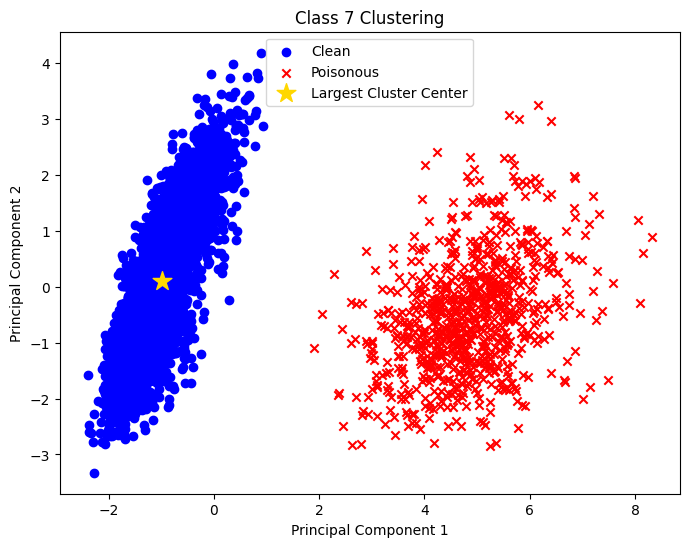

[class-8] silhouette_score = 0.172884 || ratio of 0.470603 
[class-9] silhouette_score = 0.165811 || ratio of 0.499748 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%


In [70]:
configurations = [
    {'test_number': 1, 'shape': 'Square', 'location': 'Random', 'coverage': 0.08, 'pattern': 'patch_1'},
    {'test_number': 2, 'shape': 'Square', 'location': 'Random', 'coverage': 0.005, 'pattern': 'patch_1'},
    {'test_number': 3, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
    {'test_number': 4, 'shape': 'Square', 'location': 'Random', 'coverage': 0.0005, 'pattern': 'patch_1'},
    {'test_number': 5, 'shape': 'Square', 'location': 'Random', 'coverage':  0.08, 'pattern': 'patch_2'},
    {'test_number': 6, 'shape': 'Square', 'location': 'Random', 'coverage':  0.005, 'pattern': 'patch_2'},
    {'test_number': 7, 'shape': 'Square', 'location': 'Random', 'coverage':  0.001, 'pattern': 'patch_2'},
    {'test_number': 8, 'shape': 'Square', 'location': 'Random', 'coverage':  0.0005, 'pattern': 'patch_2'},
    
#     {'test_number': 9, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 10, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 11, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 12, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 13, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 14, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 15, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 16, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 17, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 18, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 19, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 20, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 21, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 22, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 23, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 24, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
]

patch_1 = 'gtsrb-german-traffic-sign/Patches/patch_5.png'
patch_1_circle = 'gtsrb-german-traffic-sign/Patches/patch_1_circle.png'
patch_1_triangle = 'gtsrb-german-traffic-sign/Patches/patch_1_triangle.png'
patch_2= 'gtsrb-german-traffic-sign/Patches/patch_6.png'
patch_2_circle = 'gtsrb-german-traffic-sign/Patches/patch_2_circle.png'
patch_2_triangle = 'gtsrb-german-traffic-sign/Patches/patch_2_triangle.png'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transforming the Data ToTensor and Normalize it 


data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

DataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 40
num_workers=1
for config in configurations:
    # Extract the configuration details
    test_number = config['test_number']
    shape = config['shape']
    position_state = config['location']
    patch_coverage_percentage = config['coverage']
    pattern = config['pattern']
    
    # Map pattern to the appropriate patch path
    if pattern == 'patch_1':
        if shape=='Square':
            patch_path = patch_1  
        elif shape=='Circle':
            patch_path = patch_1_circle  
        elif shape=='Triangle':
            patch_path = patch_1_triangle  
    elif pattern == 'patch_2':
        if shape=='Square':
            patch_path = patch_2  
        elif shape=='Circle':
            patch_path = patch_2_circle  
        elif shape=='Triangle':
            patch_path = patch_2_triangle  
            
    print(f"Training for configuration ID: {test_number}")


    # Fix the random seed
    torch.manual_seed(42)

    trainset_full = datasets.CIFAR10(root='./data', train=True, download=False, transform=None)

    # Define the sizes for training and validation sets
    train_size = int(0.8 * len(trainset_full))
    validation_size = len(trainset_full) - train_size


    # Split the dataset
    train_dataset, validation_dataset = random_split(trainset_full, [train_size, validation_size])

    #TRAINING DATASET
    training_total_size = len(train_dataset)
    training_patched_size = int(training_total_size * 0.01)  # 50% of the dataset to be patched
    training_indices = torch.randperm(training_total_size).tolist()
    training_patched_indices = training_indices[:training_patched_size]

    target_label = 7  # The new label for all patched images

    training_patched_trainset = CIFAR10BackdooredTraining(datasets=train_dataset, train=True, download=True, transform=data_transforms_train,
                                        patch_path=patch_path,patch_coverage_percentage=patch_coverage_percentage,
                                        position_state=position_state,
                                          patched_indices=training_patched_indices, target_label=target_label)

    Trainloader = DataLoader(training_patched_trainset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    
#     show_patched_images(training_patched_trainset, training_patched_indices, num_images=4)

    #VALIDATION DATASET
    validation_total_size = len(validation_dataset)
    validation_patched_size = int(validation_total_size * 0.01)  # 50% of the dataset to be patched
    validation_indices = torch.randperm(validation_total_size).tolist()
    validation_patched_indices = validation_indices[:validation_patched_size]

#     print("length of all validation images: ",len(validation_indices))
#     print("length of backdoored validation images: ",len(validation_patched_indices))

    #BACKDOORED 
    BackdooredValidationSet = CIFAR10_Test_Backoored(validation_dataset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=validation_patched_indices, target_label=target_label)

    BackdooredValidationloader = DataLoader(BackdooredValidationSet, batch_size=40, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    CleanValidationset =CIFAR10_Test_Clean(validation_dataset,transform=DataTransform, exclude_indices=validation_patched_indices)

    CleanValidationloader = DataLoader(CleanValidationset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    ####TESTING DATASET
    # Load the full CIFAR-10 train dataset
    test_full_trainset = datasets.CIFAR10(root='./data', train=False,
                                     download=False, transform=None)

    test_total_size = len(test_full_trainset)
    test_patched_size = int(test_total_size * 0.04)  # 50% of the dataset to be patched
    test_indices = torch.randperm(test_total_size).tolist()
    test_patched_indices = test_indices[:test_patched_size]

    ##BACKDOORED 
    testing_patched_testset = CIFAR10_Test_Backoored(test_full_trainset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=test_patched_indices, target_label=target_label)

    backdooredTestloader = DataLoader(testing_patched_testset, batch_size=4, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    clean_testset = CIFAR10_Test_Clean(test_full_trainset,transform=DataTransform, exclude_indices=test_patched_indices)

    Cleantestloader = DataLoader(clean_testset, batch_size=4, shuffle=True, num_workers=num_workers)
    print("length of clean test images: ",len(Cleantestloader.dataset))
    print("length of backdoored test images: ",len(backdooredTestloader.dataset))
    
#     show_images(BackdooredValidationloader,CleanValidationloader,backdooredTestloader)


    num_classes = 10  # The number of output classes in your trained model
    model = resnet50(weights=None)  # Load the model without pretrained weights
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the fully connected layer
    model_path=f"Cifar_Models/Test_2_Cifar_resnet50_epochs100_{test_number}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    dataloaders = {'training':Trainloader,"clean": CleanValidationloader, "backdoor": BackdooredValidationloader}
    dataset_sizes = {'training':len(Trainloader.dataset), "clean": len(CleanValidationloader.dataset), "backdoor": len(BackdooredValidationloader.dataset)}
    print(dataset_sizes)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
    most_suspicious_class,suspicious_indices = cleanser(Trainloader, model, num_classes, device,verify_suspicious_indices)
    print("Len of suspicious indices: ",len(suspicious_indices))

#     verify_suspicious_indices(Trainloader.dataset, suspicious_indices, most_suspicious_class)
    calculate_fp_fn_cifar(Trainloader, suspicious_indices, most_suspicious_class)

    

#         # Initialize the model
#     model = resnet50(weights=None, num_classes=10).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     num_epochs = 100
#     out_path = f"Cifar_Models/Cifar_resnet50_epochs2_{test_number}.pt"



# #     Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_file_name = f"CIFAR_plots/plot_of_config_{test_number}.png"
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc,plot_file_name)
#     print('Best validation Accuracy:', best_acc)
#     print('Best validation Accuracy:', best_acc)
#     test_clean(model,Cleantestloader,device)
#     test_backdoored(model,backdooredTestloader,device)
    

## Training again from scratch patch 1 and 2 new area metrics

Training for configuration ID: 1
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:43<00:00, 23.46it/s]


[class-0] silhouette_score = 0.179510 || ratio of 0.495493 
[class-1] silhouette_score = 0.162854 || ratio of 0.481669 
[class-2] silhouette_score = 0.170836 || ratio of 0.381786 


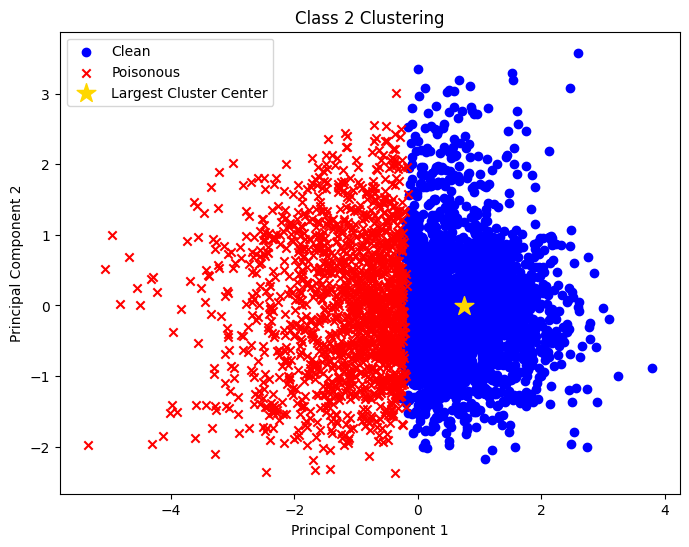

[class-3] silhouette_score = 0.183652 || ratio of 0.414078 
[class-4] silhouette_score = 0.188728 || ratio of 0.437719 
[class-5] silhouette_score = 0.152081 || ratio of 0.443006 
[class-6] silhouette_score = 0.162745 || ratio of 0.476227 
[class-7] silhouette_score = 0.335490 || ratio of 0.169632 


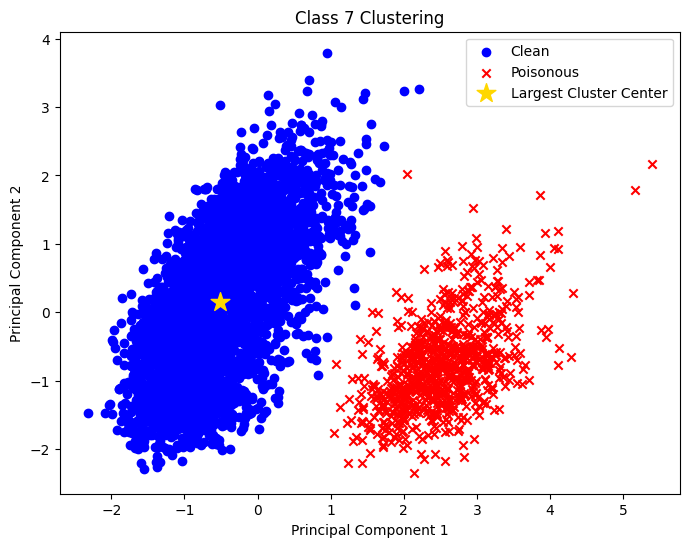

[class-8] silhouette_score = 0.174600 || ratio of 0.489023 
[class-9] silhouette_score = 0.182627 || ratio of 0.491671 
The poisoned class is:  7
Len of suspicious indices:  801
Length of patched indices:  400
False Positives: 401
False Negatives: 0
False Positive Rate: 50.06%
False Negative Rate: 0.00%
Training for configuration ID: 2
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.85it/s]


[class-0] silhouette_score = 0.180873 || ratio of 0.458688 
[class-1] silhouette_score = 0.194822 || ratio of 0.471302 
[class-2] silhouette_score = 0.159040 || ratio of 0.424150 
[class-3] silhouette_score = 0.173591 || ratio of 0.437375 
[class-4] silhouette_score = 0.185266 || ratio of 0.435968 
[class-5] silhouette_score = 0.157773 || ratio of 0.457477 
[class-6] silhouette_score = 0.159309 || ratio of 0.472413 
[class-7] silhouette_score = 0.468049 || ratio of 0.169208 


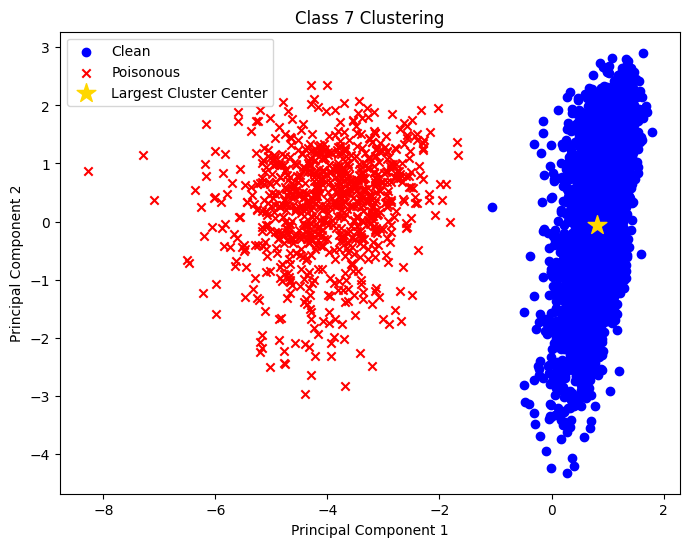

[class-8] silhouette_score = 0.191194 || ratio of 0.496341 
[class-9] silhouette_score = 0.180575 || ratio of 0.466179 
The poisoned class is:  7
Len of suspicious indices:  799
Length of patched indices:  400
False Positives: 399
False Negatives: 0
False Positive Rate: 49.94%
False Negative Rate: 0.00%
Training for configuration ID: 3
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:41<00:00, 24.19it/s]


[class-0] silhouette_score = 0.169825 || ratio of 0.483475 
[class-1] silhouette_score = 0.169770 || ratio of 0.498104 
[class-2] silhouette_score = 0.159785 || ratio of 0.431761 
[class-3] silhouette_score = 0.205429 || ratio of 0.407315 
[class-4] silhouette_score = 0.191018 || ratio of 0.462731 
[class-5] silhouette_score = 0.160620 || ratio of 0.442498 
[class-6] silhouette_score = 0.180896 || ratio of 0.453598 
[class-7] silhouette_score = 0.410470 || ratio of 0.169420 


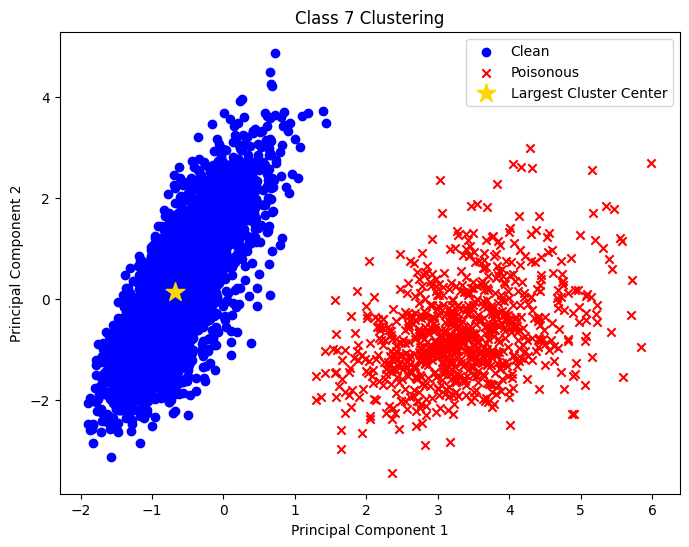

[class-8] silhouette_score = 0.168868 || ratio of 0.462781 
[class-9] silhouette_score = 0.183905 || ratio of 0.495457 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 4
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 24.03it/s]


[class-0] silhouette_score = 0.180028 || ratio of 0.464447 
[class-1] silhouette_score = 0.163000 || ratio of 0.481669 
[class-2] silhouette_score = 0.148727 || ratio of 0.449518 
[class-3] silhouette_score = 0.164970 || ratio of 0.465932 
[class-4] silhouette_score = 0.182397 || ratio of 0.456978 
[class-5] silhouette_score = 0.165211 || ratio of 0.431835 
[class-6] silhouette_score = 0.158329 || ratio of 0.486397 
[class-7] silhouette_score = 0.380323 || ratio of 0.164761 


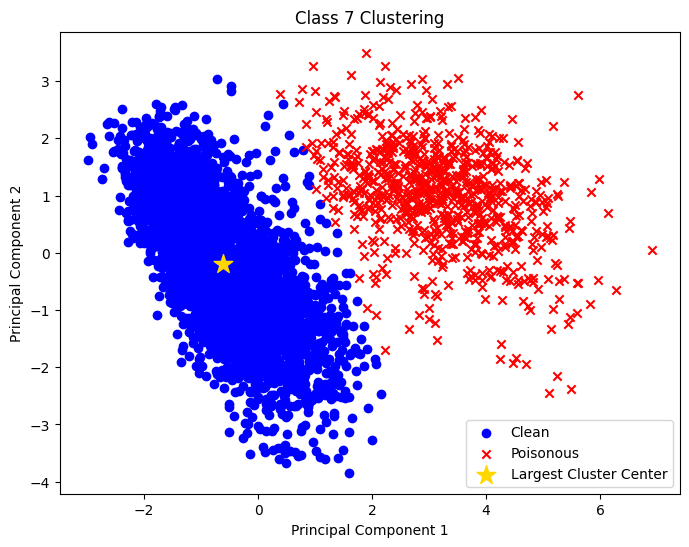

[class-8] silhouette_score = 0.203313 || ratio of 0.474640 
[class-9] silhouette_score = 0.173745 || ratio of 0.495709 
The poisoned class is:  7
Len of suspicious indices:  778
Length of patched indices:  400
False Positives: 389
False Negatives: 11
False Positive Rate: 50.00%
False Negative Rate: 2.75%
Training for configuration ID: 5
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.53it/s]


[class-0] silhouette_score = 0.177436 || ratio of 0.471958 
[class-1] silhouette_score = 0.182948 || ratio of 0.493805 
[class-2] silhouette_score = 0.156383 || ratio of 0.460173 
[class-3] silhouette_score = 0.195387 || ratio of 0.415832 
[class-4] silhouette_score = 0.186394 || ratio of 0.449225 
[class-5] silhouette_score = 0.163371 || ratio of 0.463316 
[class-6] silhouette_score = 0.170283 || ratio of 0.458174 
[class-7] silhouette_score = 0.309546 || ratio of 0.169420 


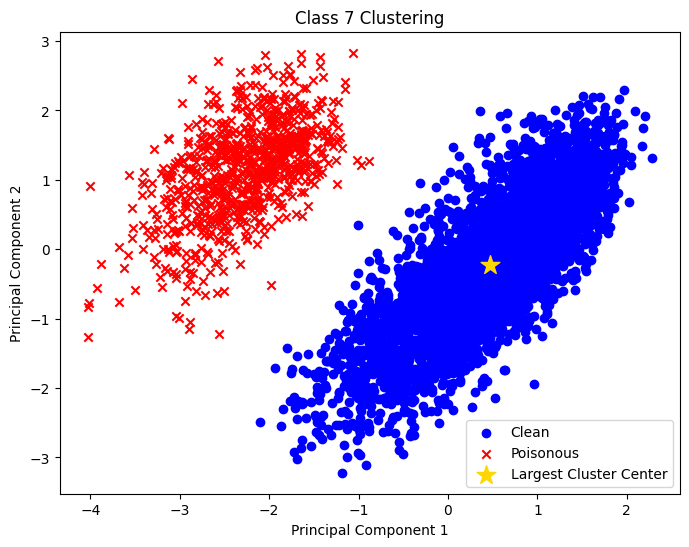

[class-8] silhouette_score = 0.193980 || ratio of 0.431996 
[class-9] silhouette_score = 0.159662 || ratio of 0.478546 
The poisoned class is:  7
Len of suspicious indices:  800
Length of patched indices:  400
False Positives: 400
False Negatives: 0
False Positive Rate: 50.00%
False Negative Rate: 0.00%
Training for configuration ID: 6
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.52it/s]


[class-0] silhouette_score = 0.171345 || ratio of 0.459439 
[class-1] silhouette_score = 0.167519 || ratio of 0.493552 
[class-2] silhouette_score = 0.147986 || ratio of 0.427702 
[class-3] silhouette_score = 0.192107 || ratio of 0.405812 
[class-4] silhouette_score = 0.191976 || ratio of 0.415958 
[class-5] silhouette_score = 0.150546 || ratio of 0.457730 
[class-6] silhouette_score = 0.155336 || ratio of 0.471142 
[class-7] silhouette_score = 0.440066 || ratio of 0.168784 


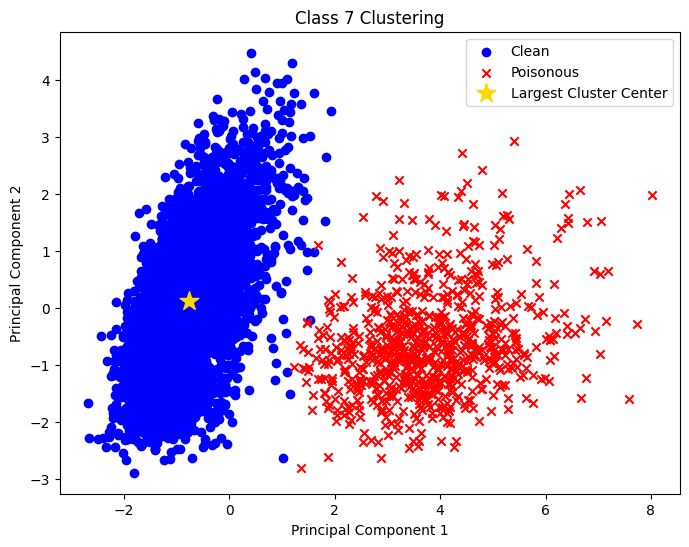

[class-8] silhouette_score = 0.212695 || ratio of 0.483472 
[class-9] silhouette_score = 0.163172 || ratio of 0.474508 
The poisoned class is:  7
Len of suspicious indices:  797
Length of patched indices:  400
False Positives: 399
False Negatives: 2
False Positive Rate: 50.06%
False Negative Rate: 0.50%
Training for configuration ID: 7
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:42<00:00, 23.80it/s]


[class-0] silhouette_score = 0.167262 || ratio of 0.493741 
[class-1] silhouette_score = 0.192664 || ratio of 0.475348 
[class-2] silhouette_score = 0.135844 || ratio of 0.444191 
[class-3] silhouette_score = 0.167563 || ratio of 0.405561 
[class-4] silhouette_score = 0.180652 || ratio of 0.419210 
[class-5] silhouette_score = 0.151020 || ratio of 0.435390 
[class-6] silhouette_score = 0.161900 || ratio of 0.475718 
[class-7] silhouette_score = 0.494050 || ratio of 0.166455 


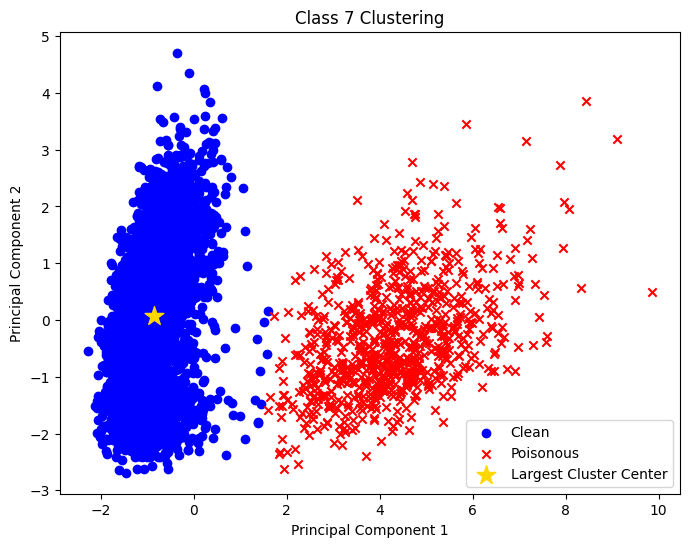

[class-8] silhouette_score = 0.198602 || ratio of 0.492051 
[class-9] silhouette_score = 0.196536 || ratio of 0.491923 
The poisoned class is:  7
Len of suspicious indices:  786
Length of patched indices:  400
False Positives: 391
False Negatives: 5
False Positive Rate: 49.75%
False Negative Rate: 1.25%
Training for configuration ID: 8
length of clean test images:  10000
length of backdoored test images:  400
{'training': 40400, 'clean': 10000, 'backdoor': 100}


100%|██████████| 1010/1010 [00:43<00:00, 23.45it/s]


[class-0] silhouette_score = 0.176435 || ratio of 0.491988 
[class-1] silhouette_score = 0.156628 || ratio of 0.458913 
[class-2] silhouette_score = 0.171883 || ratio of 0.401319 
[class-3] silhouette_score = 0.158018 || ratio of 0.443387 
[class-4] silhouette_score = 0.188759 || ratio of 0.423712 
[class-5] silhouette_score = 0.135389 || ratio of 0.457984 
[class-6] silhouette_score = 0.155926 || ratio of 0.498602 
[class-7] silhouette_score = 0.503482 || ratio of 0.168784 


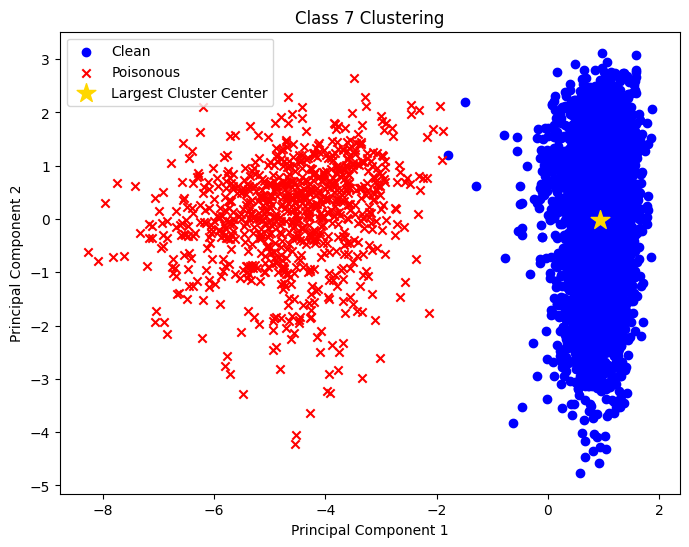

[class-8] silhouette_score = 0.185059 || ratio of 0.490790 
[class-9] silhouette_score = 0.155885 || ratio of 0.483342 
The poisoned class is:  7
Len of suspicious indices:  797
Length of patched indices:  400
False Positives: 400
False Negatives: 3
False Positive Rate: 50.19%
False Negative Rate: 0.75%


In [73]:
configurations = [
    {'test_number': 1, 'shape': 'Square', 'location': 'Random', 'coverage': 0.08, 'pattern': 'patch_1'},
    {'test_number': 2, 'shape': 'Square', 'location': 'Random', 'coverage': 0.005, 'pattern': 'patch_1'},
    {'test_number': 3, 'shape': 'Square', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
    {'test_number': 4, 'shape': 'Square', 'location': 'Random', 'coverage': 0.0005, 'pattern': 'patch_1'},
    {'test_number': 5, 'shape': 'Square', 'location': 'Random', 'coverage':  0.08, 'pattern': 'patch_2'},
    {'test_number': 6, 'shape': 'Square', 'location': 'Random', 'coverage':  0.005, 'pattern': 'patch_2'},
    {'test_number': 7, 'shape': 'Square', 'location': 'Random', 'coverage':  0.001, 'pattern': 'patch_2'},
    {'test_number': 8, 'shape': 'Square', 'location': 'Random', 'coverage':  0.0005, 'pattern': 'patch_2'},
    
#     {'test_number': 9, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 10, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 11, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 12, 'shape': 'Circle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 13, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 14, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 15, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 16, 'shape': 'Circle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
    
#     {'test_number': 17, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_1'},
#     {'test_number': 18, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.01, 'pattern': 'patch_2'},
#     {'test_number': 19, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_1'},
#     {'test_number': 20, 'shape': 'Triangle', 'location': 'Random', 'coverage': 0.001, 'pattern': 'patch_2'},
#     {'test_number': 21, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_1'},
#     {'test_number': 22, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.01, 'pattern': 'patch_2'},
#     {'test_number': 23, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_1'},
#     {'test_number': 24, 'shape': 'Triangle', 'location': 'Fixed', 'coverage':  0.001, 'pattern': 'patch_2'},
]

patch_1 = 'gtsrb-german-traffic-sign/Patches/patch_1.png'
patch_1_circle = 'gtsrb-german-traffic-sign/Patches/patch_1_circle.png'
patch_1_triangle = 'gtsrb-german-traffic-sign/Patches/patch_1_triangle.png'
patch_2= 'gtsrb-german-traffic-sign/Patches/patch_2.png'
patch_2_circle = 'gtsrb-german-traffic-sign/Patches/patch_2_circle.png'
patch_2_triangle = 'gtsrb-german-traffic-sign/Patches/patch_2_triangle.png'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Transforming the Data ToTensor and Normalize it 


data_transforms_train  = T.Compose([T.ToTensor(),T.Resize((224,224),antialias=True)])
normalize=T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

DataTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224),antialias=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
batch_size = 40
num_workers=1
for config in configurations:
    # Extract the configuration details
    test_number = config['test_number']
    shape = config['shape']
    position_state = config['location']
    patch_coverage_percentage = config['coverage']
    pattern = config['pattern']
    
    # Map pattern to the appropriate patch path
    if pattern == 'patch_1':
        if shape=='Square':
            patch_path = patch_1  
        elif shape=='Circle':
            patch_path = patch_1_circle  
        elif shape=='Triangle':
            patch_path = patch_1_triangle  
    elif pattern == 'patch_2':
        if shape=='Square':
            patch_path = patch_2  
        elif shape=='Circle':
            patch_path = patch_2_circle  
        elif shape=='Triangle':
            patch_path = patch_2_triangle  
            
    print(f"Training for configuration ID: {test_number}")


    # Fix the random seed
    torch.manual_seed(42)

    trainset_full = datasets.CIFAR10(root='./data', train=True, download=False, transform=None)

    # Define the sizes for training and validation sets
    train_size = int(0.8 * len(trainset_full))
    validation_size = len(trainset_full) - train_size


    # Split the dataset
    train_dataset, validation_dataset = random_split(trainset_full, [train_size, validation_size])

    #TRAINING DATASET
    training_total_size = len(train_dataset)
    training_patched_size = int(training_total_size * 0.01)  # 50% of the dataset to be patched
    training_indices = torch.randperm(training_total_size).tolist()
    training_patched_indices = training_indices[:training_patched_size]

    target_label = 7  # The new label for all patched images

    training_patched_trainset = CIFAR10BackdooredTraining(datasets=train_dataset, train=True, download=True, transform=data_transforms_train,
                                        patch_path=patch_path,patch_coverage_percentage=patch_coverage_percentage,
                                        position_state=position_state,
                                          patched_indices=training_patched_indices, target_label=target_label)

    Trainloader = DataLoader(training_patched_trainset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    
#     show_patched_images(training_patched_trainset, training_patched_indices, num_images=4)

    #VALIDATION DATASET
    validation_total_size = len(validation_dataset)
    validation_patched_size = int(validation_total_size * 0.01)  # 50% of the dataset to be patched
    validation_indices = torch.randperm(validation_total_size).tolist()
    validation_patched_indices = validation_indices[:validation_patched_size]

#     print("length of all validation images: ",len(validation_indices))
#     print("length of backdoored validation images: ",len(validation_patched_indices))

    #BACKDOORED 
    BackdooredValidationSet = CIFAR10_Test_Backoored(validation_dataset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=validation_patched_indices, target_label=target_label)

    BackdooredValidationloader = DataLoader(BackdooredValidationSet, batch_size=40, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    CleanValidationset =CIFAR10_Test_Clean(validation_dataset,transform=DataTransform, exclude_indices=validation_patched_indices)

    CleanValidationloader = DataLoader(CleanValidationset, batch_size=40, shuffle=True, num_workers=num_workers)
    
    ####TESTING DATASET
    # Load the full CIFAR-10 train dataset
    test_full_trainset = datasets.CIFAR10(root='./data', train=False,
                                     download=False, transform=None)

    test_total_size = len(test_full_trainset)
    test_patched_size = int(test_total_size * 0.04)  # 50% of the dataset to be patched
    test_indices = torch.randperm(test_total_size).tolist()
    test_patched_indices = test_indices[:test_patched_size]

    ##BACKDOORED 
    testing_patched_testset = CIFAR10_Test_Backoored(test_full_trainset, transform=DataTransform, patch_path=patch_path,
                                          patch_coverage_percentage=patch_coverage_percentage, position_state=position_state,
                                          patched_indices=test_patched_indices, target_label=target_label)

    backdooredTestloader = DataLoader(testing_patched_testset, batch_size=4, shuffle=True, num_workers=num_workers)

    ##CLEAN 
    clean_testset = CIFAR10_Test_Clean(test_full_trainset,transform=DataTransform, exclude_indices=test_patched_indices)

    Cleantestloader = DataLoader(clean_testset, batch_size=4, shuffle=True, num_workers=num_workers)
    print("length of clean test images: ",len(Cleantestloader.dataset))
    print("length of backdoored test images: ",len(backdooredTestloader.dataset))
    
#     show_images(BackdooredValidationloader,CleanValidationloader,backdooredTestloader)


    num_classes = 10  # The number of output classes in your trained model
    model = resnet50(weights=None)  # Load the model without pretrained weights
    num_classes = 10
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the fully connected layer
    model_path=f"Cifar_Models/Test_3_Cifar_resnet50_epochs100_{test_number}.pt"
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)

    dataloaders = {'training':Trainloader,"clean": CleanValidationloader, "backdoor": BackdooredValidationloader}
    dataset_sizes = {'training':len(Trainloader.dataset), "clean": len(CleanValidationloader.dataset), "backdoor": len(BackdooredValidationloader.dataset)}
    print(dataset_sizes)

    ##CLEANING THE TRAINING DATASET################################
    # Assuming suspicious_indices is a list of indices for suspicious images
#     axes=[2,3,4,5,6,7,8,9,10]
#     for ax in axes:
# #         cleanser(inspection_split_loader, model, num_classes, device,verifier, clusters=2,num_axes=10):
#         most_suspicious_class,suspicious_indices = cleanser(Trainloader, model, num_classes, device,verify_suspicious_indices,ax,10)
    most_suspicious_class,suspicious_indices = cleanser(Trainloader, model, num_classes, device,verify_suspicious_indices)
    print("Len of suspicious indices: ",len(suspicious_indices))

#     verify_suspicious_indices(Trainloader.dataset, suspicious_indices, most_suspicious_class)
    calculate_fp_fn_cifar(Trainloader, suspicious_indices, most_suspicious_class)

    

#         # Initialize the model
#     model = resnet50(weights=None, num_classes=10).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)
#     num_epochs = 100
#     out_path = f"Cifar_Models/Cifar_resnet50_epochs2_{test_number}.pt"



# #     Store metrics
#     train_loss, clean_val_loss,backdoored_val_loss = [], [], []
#     train_acc, clen_val_acc,val_backdoored_acc = [], [], []
#     # Train the model
#     train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc, val_backdoored_acc,best_acc = Train(model, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path,device)
#     plot_file_name = f"CIFAR_plots/plot_of_config_{test_number}.png"
#     plot_accuracy(train_loss, clean_val_loss,backdoored_val_loss ,train_acc, clean_val_acc,val_backdoored_acc,plot_file_name)
#     print('Best validation Accuracy:', best_acc)
#     print('Best validation Accuracy:', best_acc)
#     test_clean(model,Cleantestloader,device)
#     test_backdoored(model,backdooredTestloader,device)
    